# Control Behavior Data Processing

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math
import pandas as pd
import glob2 as glob
import seaborn as sns
from datetime import date
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import cv2

## Prep and Analysis ##

### Importing metadata and calculating Ns

In [957]:
filename = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_ControlBehavior_Metadata.csv'
metadata = pd.read_csv(filename, header=0)
metadata = metadata.replace('Lil Guy', 'LilGuy')

In [958]:
metadata.head(4)

,Include,ID,Cage,Sex,Generation,Parents,Line,X1A GT,DOB,Age,...,TCT_start,TCT_stop,OFT_Date,OFT_Time,OFT_filename,OFT_start,OFT_stop,Sac_Date,Repeat_Genotyping,Notes
0,True,E0443,4876756,M,F8,N56,X1,Het,8/3/23,5m 19d,...,1960.0,2560.0,9/28/23,3:03 PM,/Users/joshsteighner/Library/CloudStorage/Box-...,28.0,628.0,9/29/23,Het,Formerly E0379 (het)
1,True,E0441,4876756,M,F8,N56,X1,Het,8/3/23,5m 19d,...,1961.0,2561.0,9/28/23,3:23 PM,/Users/joshsteighner/Library/CloudStorage/Box-...,24.0,624.0,9/29/23,Het,Formerly E0380 or E0381 (both het)
2,True,Biggie,4876756,M,F8,N56,X1,WT,8/3/23,5m 19d,...,1963.0,2563.0,9/28/23,3:40 PM,/Users/joshsteighner/Library/CloudStorage/Box-...,32.0,632.0,9/29/23,WT,"No tag, larger animal; Formerly E0442 (formerl..."
3,True,LilGuy,4876756,M,F8,N56,X1,Het,8/3/23,5m 19d,...,1957.0,2557.0,9/28/23,3:54 PM,/Users/joshsteighner/Library/CloudStorage/Box-...,17.0,617.0,9/29/23,Het,"No tag, smaller animal; Formerly E0442 (former..."


In [756]:
def sexbygeno_Inventory(count_sex, count_geno,df):
    # eg sexbygeno_Inventory('M','WT')
    num_run = len(df[(df["TCT_Lane"]>=1) & (df["Include"]==1)& (df["Sex"]==count_sex)& (df["X1A GT"]==count_geno)])
    num_planned = len(df[(df["Include"]==1)& (df["Sex"]==count_sex)& (df["X1A GT"]==count_geno)])
    if count_sex == 'M':
        sex_word = 'males'
    elif count_sex == 'F':
        sex_word = 'females'
    
    print('A total of ' + str(num_run) + ' '+ count_geno + ' ' + sex_word +' have been run, out of ' + str(num_planned) + ' planned.')        

In [959]:
for sex in ['M', 'F']:
    for geno in ['WT','Het']:
        sexbygeno_Inventory(sex, geno, metadata)

A total of 11 WT males have been run, out of 11 planned.
A total of 12 Het males have been run, out of 12 planned.
A total of 13 WT females have been run, out of 13 planned.
A total of 12 Het females have been run, out of 12 planned.


In [960]:
d = {'ID': metadata[metadata["Include"]==1]["ID"], 'Sex': metadata[metadata["Include"]==1]["Sex"],'Geno': metadata[metadata["Include"]==1]["X1A GT"]}
controlData = pd.DataFrame(data = d)
controlData = controlData.reset_index(drop=True)

### Making OFT scripts

The prep file for the OFTs (prep_solo_abs.sh) lays out the syntax for running a the prep stage in the terminal. You will need the paths for the parameters .py file, the input .mp4, and output .parameters file:
    python solo_absolute/pick_job_parameters_solo.py --input_video testvideo.mp4 --output_jobfile testvideo.parameters

In [761]:
ID_list = ['E1196', 'E1203', 'E1224']

#metadata[(metadata["TCT_Lane"]>=1) & (metadata["Include"]==1)]["ID"]
#OFT_fileList = metadata[(metadata["TCT_Lane"]>=1) & (metadata["Include"]==1)]["OFT_filename"]

OFT_path = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/'
OFTprep_code = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/dlc-prototyping/contours_beta/solo_absolute/pick_job_parameters_solo.py'
OFT_parameters = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_OFT/OFT_parameters/'
OFT_prepCommandList = []

for id in ID_list:
    filename = glob.glob(OFT_path + '*' + id + '*')[0]
    OFT_command = 'python '+ OFTprep_code + ' --input_video '+ filename + ' --output_jobfile ' + OFT_parameters + id + '_OFT.parameters'   
    # print('Making script for ' + id + ' OFT ...')
    OFT_prepCommandList.append(OFT_command)
print('Made scripts for '+ str(len(OFT_prepCommandList)) + ' files')

Made scripts for 5 files


In [762]:
from datetime import date
date.today().strftime("%Y%m%d")    

commandFileName = OFT_path + 'OFT_prepCommand_' + date.today().strftime("%Y%m%d") + '.txt'
with open(commandFileName, 'w') as f:
    for line in OFT_prepCommandList:
        f.write(line)
        f.write('\n')
print('Command script path: ' + commandFileName)

Command script path: /Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/OFT_prepCommand_20240122.txt


The scoring file (score_solo_abs.sh) has the formatting instructions for how to run the open field analysis. You will need the video and parameters paths, as well as a filenames for both contours & video outputs, and start & end timestamps (s): 
python solo_absolute/score_solo_assay.py --input_video testvideo.mp4 --jobfile testvideo.parameters --output_contours testvideo.contours --output_video testvideo.tracked.mp4 --start_time 1870 --end_time 1920

In [778]:
ID_list = ['E1196', 'E1203', 'E1224']
#ID_list = metadata[(metadata["TCT_Lane"]>=1) & (metadata["Include"]==1)]["ID"]
#OFT_fileList = metadata[(metadata["TCT_Lane"]>=1) & (metadata["Include"]==1)]["OFT_filename"]
OFT_starts = metadata[(metadata["TCT_Lane"]>=1) & (metadata["Include"]==1)]["OFT_start"]

OFTscore_code = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/dlc-prototyping/contours_beta/solo_absolute/score_solo_assay.py'
OFT_parameters = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_OFT/OFT_parameters/'
OFT_scored = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/OFT_scored/'
OFT_scoreCommandList = []

for id in ID_list:
    start = metadata[metadata["ID"]==id]["OFT_start"]
    filename = glob.glob(OFT_path + '*' + id + '*')[0]
    OFT_command = 'python '+ OFTscore_code + ' --input_video ' + filename + ' --jobfile ' + OFT_parameters + id + '_OFT.parameters --output_contours ' + OFT_scored + id + '_OFT.contours --output_video ' + OFT_scored + id + '_OFT_tracked.mp4 --start_time ' + str(round(start.item())+1) + ' --end_time ' + str(round(start.item())+601)
    OFT_scoreCommandList.append(OFT_command)
print('Made scripts for '+ str(len(OFT_scoreCommandList)) + ' files')

Made scripts for 3 files


In [779]:
from datetime import date
date.today().strftime("%Y%m%d")    

OFT_path = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/'
commandFileName = OFT_path + 'OFT_score_plus1' + date.today().strftime("%Y%m%d") + '.sh'
with open(commandFileName, 'w') as f:
    f.write('#!/bin/sh')
    f.write('\n')
    
    for line in OFT_scoreCommandList:
        f.write(line)
        f.write('\n')
print('Command script path: ' + commandFileName)

Command script path: /Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/OFT_score_plus120240122.sh


In [189]:
OFT_scoreCommandList[0]

'python /Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/dlc-prototyping/contours_beta/solo_absolute/score_solo_assay.py --input_video /Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/20230928_E0443.mp4 --jobfile /Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_OFT/OFT_parameters/E0443_OFT.parameters --output_contours /Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/OFT_scored/E0443_OFT.contours --output_video /Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/OFT_scored/E0443_OFT_tracked.mp4 --start_time 28 --end_time 628'

In [427]:
def scoringProgress(id_list, outputPath):
    import glob2 as glob
    numInput = len(id_list)
    numContours = len(glob.glob(outputPath + '*contours*'))
    numOutput = len(glob.glob(outputPath + '*mp4*'))
    delta = numOutput - numContours
    
    print(str(numContours) + ' videos scored out of ' + str(numInput) + ', with ' + str(round(delta))  + ' in progress (' + str(round((numContours/numInput*100),2)) + '%)')

In [773]:
OFT_path = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/'
scoringProgress(ID_list, OFT_scored)

47 videos scored out of 5, with 1 in progress (940.0%)


### Calculating OFT Metrics ###

In [459]:
def addDeltas(contour_df, time_col = "time"):
    times = contour_df[time_col]
    deltas = np.ndarray(shape=len(times), dtype=np.float64)
    # delta time is added in the row corresponding to the second time-point, leaving the first frame as 0
    for t in range(len(times)):
        if t == 0:
            deltas[t] = 0
        else:
            deltas[t] = (times[t] - times[t-1])
        
    contour_df.insert(3, 'delta_time', deltas,False)
    return
    contour_df

In [803]:
controlData.head(4)

,ID,Sex,Geno,oft_datetime,oft_nanList,oft_Outer,oft_Center,oft_Distance_px,tct_stimSide,tct_nanList,tct_StimSide,tct_Center,tct_ObjSide,tct_StimIntxn,tct_NoIntxn,tct_ObjIntxn
0,E0443,M,Het,"9/28/23, 3:03 PM",None,0.820503,0.179497,89640.526340,Left,"Int64Index([8988, 8989, 8990, 8991, 8992, 8993...",0.540163,0.113218,0.346620,0.307245,0.550486,0.142270
1,E0441,M,Het,"9/28/23, 3:23 PM",None,0.917039,0.082961,45625.481607,Right,"Int64Index([], dtype='int64')",0.276681,0.723319,0.000000,0.167242,0.832758,0.000000
2,Biggie,M,WT,"9/28/23, 3:40 PM",None,0.954746,0.045254,50958.268518,Right,"Int64Index([10621, 10622, 10623, 10624, 10625,...",0.493616,0.207026,0.299357,0.245836,0.606196,0.147968
3,LilGuy,M,Het,"9/28/23, 3:54 PM",None,0.930694,0.069306,111641.395836,Left,"Int64Index([], dtype='int64')",0.483117,0.034962,0.481921,0.322458,0.538657,0.138885


In [802]:
def cmltvRegion_oft(contour_df, plot=0):
    times = contour_df["time"]
    cmltv_outer = np.ndarray(shape=len(times), dtype=np.float64)
    cmltv_center = np.ndarray(shape=len(times), dtype=np.float64)
    cmltv_distance = np.ndarray(shape=len(times), dtype=np.float64)
    total_time = np.sum(contour_df[pd.notna(contour_df["region"])]["delta_time"])
    
    for i in range(len(times)):
        delta = contour_df["delta_time"][i]
        
        if i == 0:
            cmltv_outer[i] = 0
            cmltv_center[i] = 0
            cmltv_distance[i] = 0

        else:
            delta_x = contour_df["pos_x"][i]-contour_df["pos_x"][i-1]
            delta_y = contour_df["pos_y"][i]-contour_df["pos_y"][i-1]
            delta_distance = np.sqrt(np.square(delta_x) + np.square(delta_y))
            cmltv_distance[i] = cmltv_distance[i-1] + delta_distance
            
            if contour_df["region"][i]=="OUTER":
                cmltv_outer[i] = cmltv_outer[i-1] + delta
                cmltv_center[i] = cmltv_center[i-1]

            elif contour_df["region"][i]=="CENTER":   
                cmltv_outer[i] = cmltv_outer[i-1]
                cmltv_center[i] = cmltv_center[i-1] + delta
            else: 
                cmltv_outer[i] = cmltv_outer[i-1]
                cmltv_center[i] = cmltv_center[i-1]
                
    if plot > 0:
        plt.plot((times-times[0]), cmltv_outer,label='Outer')
        plt.plot((times-times[0]), cmltv_center, label = 'Center')
        plt.xlabel("Time (s)")
        plt.ylabel("Cumulative time in region")
        plt.legend()
    
    return cmltv_outer, cmltv_center, cmltv_distance, total_time

In [13]:
def sexbygeno_Index(sex, geno,df,nan_column):
    # e.g. wtm_idx = sexbygeno_Index('M', 'WT',controlData,"oft_datetime")
    idx = pd.notna(df[nan_column]) & (df["Sex"] == sex) & (df["Geno"] == geno)
    return idx

(array([0.00000000e+00, 3.19666667e-02, 6.36333333e-02, ...,
        5.24846667e+02, 5.24878767e+02, 5.24910633e+02]),
 array([ 0.    ,  0.    ,  0.    , ..., 75.0557, 75.0557, 75.0557]))

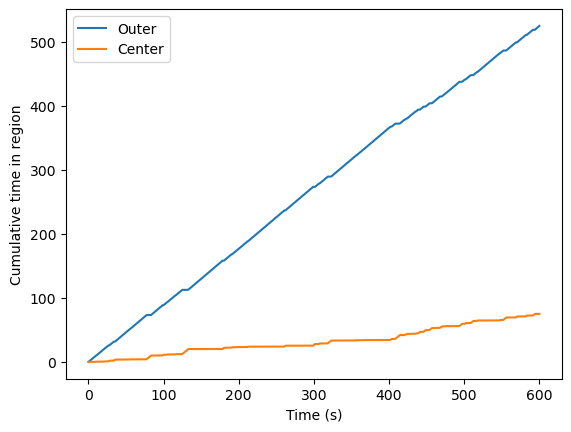

In [402]:
# eg:
cmltvRegion(oftTest,1)

In [728]:
def regionMeans_by_geno(df, region, geno, target_column='region'):
    # e.g. regionMeans_by_geno(male_Data, "outer", "WT")
    # e.g. regionMeans_by_geno(male_Data, "object", "WT",'Side')    
    mean = np.mean(df[(df["Geno"]==geno) & (df[target_column]==region)]["regionTime"])
    sem = scipy.stats.sem(df[(df["Geno"]==geno) & (df[target_column]==region)]["regionTime"])
    
    return mean, sem

In [956]:
def oftDiagonal_px(parameter_file, wall_or_hypot = 'wall'):
    parameters = pd.read_csv(parameter_file, header=0)
    coords_str = parameters["CENTER_REGION_CORNERS"][0]
    coords_str = coords_str.split(',')
    xTL, yTL, xTR, yTR, xBR, yBR, xBL, yBL = [float(num) for num in coords_str]
    
    if wall_or_hypot == 'wall':
        wallT = np.sqrt(np.square((xTL-xTR)) + np.square((yTL-yTR)))
        wallR = np.sqrt(np.square((xTR-xBR)) + np.square((yTR-yBR)))
        wallB = np.sqrt(np.square((xBL-xBR)) + np.square((yBL-yBR)))
        wallL = np.sqrt(np.square((xTL-xBL)) + np.square((yTL-yBL)))
        wall_ave = np.mean([wallT,wallR,wallB,wallL])
        return wall_ave
    elif wall_or_hypot == 'hypot':
        hypot_1 = np.sqrt(np.square((xTL-xBR)) + np.square((yTL-yBR)))
        hypot_2 = np.sqrt(np.square((xTR-xBL)) + np.square((yTR-yBL)))
        hypot_ave = np.mean([hypot_1,hypot_2])
        return hypot_ave

In [961]:
oft_DateTime = metadata[metadata["Include"]==1]["OFT_Date"] + ', ' + metadata[metadata["Include"]==1]["OFT_Time"]
oft_DateTime = oft_DateTime.reset_index(drop=True)
controlData.insert(3, 'oft_datetime', oft_DateTime, False)

In [962]:
OFT_scored = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/SCN2AX1_OFT/OFT_scored/'
OFT_NaN_List = np.empty(shape=len(controlData), dtype=object)
for i,id in zip(range(np.sum(pd.notna(controlData["oft_datetime"]))),controlData[pd.notna(controlData["oft_datetime"])]["ID"]):
    contourPath = glob.glob(OFT_scored + '*' + id + '*' + '*contours*')
    oft = pd.read_csv(contourPath[0], header=0)
    addDeltas(oft)
    nanIdx, text = nanDetect(oft)
    NaN_List[i] = nanIdx
    print(id + ': ' + text)

controlData.insert(4, 'oft_nanList', OFT_NaN_List, False)    
controlData.tail(6)    

E0443: No NaNs detected
E0441: No NaNs detected
Biggie: No NaNs detected
LilGuy: No NaNs detected
B8261: No NaNs detected
B8262: No NaNs detected
B8263: No NaNs detected
B8264: No NaNs detected
E0437: No NaNs detected
E0440: No NaNs detected
E0434: No NaNs detected
E0435: No NaNs detected
E0439: No NaNs detected
E0484: No NaNs detected
E0490: No NaNs detected
E0492: No NaNs detected
E0487: No NaNs detected
E0488: No NaNs detected
E0489: No NaNs detected
E0491: No NaNs detected
E0596: No NaNs detected
E0598: No NaNs detected
E0946: No NaNs detected
E0948: No NaNs detected
E0597: No NaNs detected
E0599: No NaNs detected
E0947: No NaNs detected
E0701: No NaNs detected
E0729: No NaNs detected
E0730: No NaNs detected
E0731: No NaNs detected
E0829: No NaNs detected
E0834: No NaNs detected
E0837: No NaNs detected
E0838: No NaNs detected
E0831: No NaNs detected
E0833: No NaNs detected
E0835: No NaNs detected
E0839: No NaNs detected
E0843: No NaNs detected
E1011: No NaNs detected
E1012: No NaNs

,ID,Sex,Geno,oft_datetime,oft_nanList
43,E1018,M,NaN,"1/4/24, 2:11 PM",None
44,E1196,M,WT,"1/19/24, 2:52 PM",None
45,E1201,M,WT,"1/19/24, 2:39 PM",None
46,E1203,F,Het,"1/19/24, 1:38 PM",None
47,E1224,F,WT,"1/19/24, 1:57 PM",None
48,E1225,M,WT,"1/19/24, 2:16 PM",None


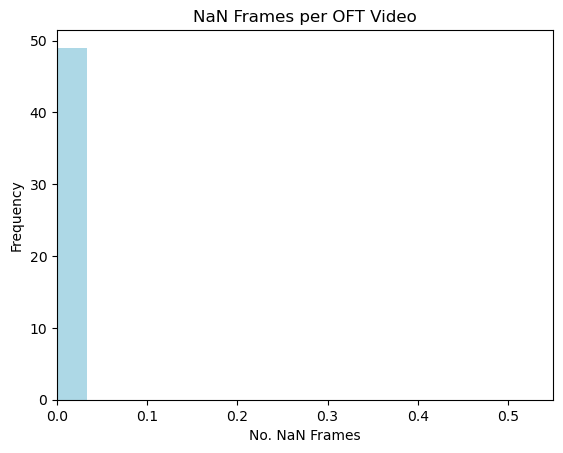

In [1040]:
num_NaNs = np.full(shape = np.sum(pd.notna(controlData["oft_datetime"])), fill_value = 0, dtype=np.float64)
for i in range(len(controlData[pd.notna(controlData["oft_datetime"])]["oft_nanList"])):
    if controlData["oft_nanList"][i] == None:
        num_NaNs[i] = 0
    else: num_NaNs[i] = len(controlData["oft_nanList"][i])

plt.hist(num_NaNs, bins=30, color='lightblue', edgecolor='none')
plt.xlabel('No. NaN Frames')
plt.ylabel('Frequency')
plt.title('NaN Frames per OFT Video')
plt.xlim(left = 0)
plt.show()

In [969]:
OFT_cm_px = np.empty(shape=len(controlData), dtype=object)
for i,id in zip(range(np.sum(pd.notna(controlData["oft_datetime"]))),controlData[pd.notna(controlData["oft_datetime"])]["ID"]):
    parameter_file = glob.glob(OFT_parameters + '*' + id + '*')[0]
    wall_len_px = oftDiagonal_px(parameter_file)
    OFT_cm_px[i] = 58/wall_len_px #each eall is appx 58cm, so dividing by average wall length in px yields cm/px conversion
controlData.insert(5, 'oft_cm_px', OFT_cm_px, False)
controlData.loc[pd.isna(controlData['oft_datetime']),'oft_cm_px'] = np.nan 

In [970]:
controlData.head(4)

,ID,Sex,Geno,oft_datetime,oft_nanList,oft_cm_px
0,E0443,M,Het,"9/28/23, 3:03 PM",None,0.101888
1,E0441,M,Het,"9/28/23, 3:23 PM",None,0.10197
2,Biggie,M,WT,"9/28/23, 3:40 PM",None,0.101779
3,LilGuy,M,Het,"9/28/23, 3:54 PM",None,0.101927


In [973]:
cmltv_Outer = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)
cmltv_Center = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)
cmltv_Distance_px = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)
cmltv_Distance_cm = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)

for i in range(len(controlData["ID"])):
    contourPath = glob.glob(OFT_scored + '*' + controlData["ID"][i] + '*' + '*contours*')
    if len(contourPath) > 0:
        oft = pd.read_csv(contourPath[0], header=0)
        addDeltas(oft)        
        cmltv_outer, cmltv_center, cmltv_distance, total_time = cmltvRegion_oft(oft)
        cmltv_Outer[i] = cmltv_outer[-1]/total_time
        cmltv_Center[i] = cmltv_center[-1]/total_time
        cmltv_Distance_px[i] = cmltv_distance[-1]
        cmltv_Distance_cm[i] = (cmltv_distance[-1]*controlData["oft_cm_px"][i])
        print(controlData["ID"][i] + ': outer = ' + str(round(cmltv_outer[-1],2)) + ', center = ' + str(round(cmltv_center[-1],2)) +' , distance = ' + str(round(cmltv_distance[-1],2)) + 'px or ' + str(round(cmltv_Distance_cm[i],2)) + 'cm, assay time = '+str(round(total_time))+'s')

E0443: outer = 492.29, center = 107.7 , distance = 89640.53px or 9133.28cm, assay time = 600s
E0441: outer = 550.22, center = 49.78 , distance = 45625.48px or 4652.43cm, assay time = 600s
Biggie: outer = 572.82, center = 27.15 , distance = 50958.27px or 5186.49cm, assay time = 600s
LilGuy: outer = 558.42, center = 41.58 , distance = 111641.4px or 11379.26cm, assay time = 600s
B8261: outer = 548.59, center = 51.42 , distance = 48361.57px or 4888.62cm, assay time = 600s
B8262: outer = 550.85, center = 49.13 , distance = 73802.75px or 7496.33cm, assay time = 600s
B8263: outer = 561.18, center = 38.82 , distance = 30133.83px or 3035.25cm, assay time = 600s
B8264: outer = 530.21, center = 69.76 , distance = 79633.89px or 8131.0cm, assay time = 600s
E0437: outer = 534.74, center = 65.26 , distance = 52235.69px or 5288.49cm, assay time = 600s
E0440: outer = 557.57, center = 42.42 , distance = 44635.55px or 4502.06cm, assay time = 600s
E0434: outer = 580.97, center = 18.99 , distance = 38309.3

In [974]:
controlData.insert(6, 'oft_Outer', cmltv_Outer, False)
controlData.insert(7, 'oft_Center', cmltv_Center, False)
controlData.insert(8, 'oft_Distance_px', cmltv_Distance_px, False)
controlData.insert(9, 'oft_Distance_cm', cmltv_Distance_cm, False)
controlData.loc[pd.isna(controlData['oft_datetime']),'oft_Outer'] = np.nan
controlData.loc[pd.isna(controlData['oft_datetime']),'oft_Center'] = np.nan
controlData.loc[pd.isna(controlData['oft_datetime']),'oft_Distance_px'] = np.nan
controlData.loc[pd.isna(controlData['oft_datetime']),'oft_Distance_cm'] = np.nan

In [979]:
controlData.tail(7)

,ID,Sex,Geno,oft_datetime,oft_nanList,oft_cm_px,oft_Outer,oft_Center,oft_Distance_px,oft_Distance_cm
42,E1016,M,WT,"1/4/24, 2:25 PM",None,0.101395,0.919252,0.080748,97596.165407,9895.796970
43,E1018,M,NaN,"1/4/24, 2:11 PM",None,0.101482,0.808694,0.191306,49156.249262,4988.487123
44,E1196,M,WT,"1/19/24, 2:52 PM",None,0.101594,0.906105,0.093895,51161.324789,5197.678821
45,E1201,M,WT,"1/19/24, 2:39 PM",None,0.100509,0.858710,0.141290,92779.299433,9325.111696
46,E1203,F,Het,"1/19/24, 1:38 PM",None,0.100684,0.834505,0.165495,121427.478635,12225.810433
47,E1224,F,WT,"1/19/24, 1:57 PM",None,0.099644,0.786860,0.213140,64392.875652,6416.382165
48,E1225,M,WT,"1/19/24, 2:16 PM",None,0.101541,0.927708,0.072292,29347.744951,2979.999816


### Making TCT Scripts

In [222]:
def vidTrim(df, f, file_col, start_col, stop_col, output_path, id_col="ID", incl_col="Include", na_col="TCT_lane"):
    # vidTrim(metadata, TCT_files[i], "TCT_filename", "TCT_start", "TCT_stop", TCTtrim_path)
    
    ids = df[(df[file_col]==f.replace('.mp4',''))][id_col]
    ids = ids.reset_index(drop=True)
    print(f)
  
    if len(ids) == 1:
        starts = np.full(shape=1, fill_value = 0, dtype=np.float64)
        start_v0 = df[(df[id_col]==ids[0])][start_col]
        starts[0] = start_v0
        start = starts[0]
        
        stops = np.full(shape=1, fill_value = 0, dtype=np.float64)
        stop_v0 = df[(df[id_col]==ids[0])][stop_col]
        stops[0] = stop_v0
        stop = stops[0]        
        print('start(s) = ' + str(start) + ', stop(s) = ' + str(stop))
        
    elif len(ids) == 2:
        starts = np.full(shape=2, fill_value = 0, dtype=np.float64)
        starts[0] = df[(df[id_col]==ids[0])][start_col]
        starts[1] = df[(df[id_col]==ids[1])][start_col]
        start = np.min(starts)

        stops = np.full(shape=2, fill_value = 0, dtype=np.float64)
        stops[0] = df[(df[id_col]==ids[0])][stop_col]
        stops[1] = df[(df[id_col]==ids[1])][stop_col]
        stop = np.max(stops)
        print('start(s) = ' + str(starts[0]) + ', ' + str(starts[1]) + '; stop(s) = ' + str(stops[0]) + ', ' + str(stops[1]))

    elif len(ids) > 2: 
        print('ERROR: more than 2 IDs match with video file')
    
    
    if start <= 30:
        t1 = 0
    elif start > 30:
        t1 = start - 30

    t2 = stop + 30    
    output_name = output_path + (f.split('/')[-1]).replace('.mp4','') + '_trim.mp4'
    ffmpeg_extract_subclip(f, t1, t2, targetname=output_name)
    print('---> ' + (f.split('/')[-1]).replace('.mp4','') + '_trim.mp4' + ': trimmed to ' + str(t1) + ' to ' + str(t2))

    return output_name, t1, t2

In [872]:

for id in ['E1196', 'E1201', 'E1203', 'E1224', 'E1225']:
    vid = glob.glob(TCT_path + '*' + id +'*mp4*')
    vidTrim(metadata, vid[0], "TCT_filename", "TCT_start", "TCT_stop", TCTtrim_path)    

/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_TCT/20240117_2E1196.mp4
start(s) = 1828.0, stop(s) = 2428.0
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
---> 20240117_2E1196_trim.mp4: trimmed to 1798.0 to 2458.0
/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_TCT/20240117_3TopE1225_1BottomE1201.mp4
start(s) = 1837.0, 1840.0; stop(s) = 2437.0, 2440.0
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
---> 20240117_3TopE1225_1BottomE1201_trim.mp4: trimmed to 1807.0 to 2470.0
/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_TCT/20240117_1E1203.mp4
start(s) = 1550.0, stop(s) = 2150.0
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
---> 20240117_1E1203_trim.mp4: trimmed to 1520.0 to 2180.0
/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_

In [873]:
print('Of ' + str(len(glob.glob(TCT_path + '*mp4*'))) + ' TCT videos, ' + str(len(glob.glob(TCTtrim_path + '*mp4*'))) + ' have been trimmed')

Of 35 TCT videos, 35 have been trimmed


The file named “prep_solo_abs.sh” has the formatting instructions for how to prep the open field analysis. You can read it by entering: cat prep_tct_abs.bat. It reads:
python tct_absolute/pick_job_parameters_tct.py --input_video testtct.mp4 --output_jobfile testtct.parameters

In [874]:
TCT_prepCommandList = []
for id in ['E1196', 'E1201', 'E1203', 'E1224', 'E1225']:
    inputVid = glob.glob(TCTtrim_path + '*' + id + '*')[0]
    TCT_command = 'python ' + TCTprep_code + ' --input_video ' + inputVid + ' --output_jobfile ' + TCT_parameters + id + '_TCT.parameters'
    TCT_prepCommandList.append(TCT_command)
print('Made scripts for '+ str(len(TCT_prepCommandList)) + ' files')

from datetime import date   
commandFileName = TCT_path + 'TCT_prepCommand_' + date.today().strftime("%Y%m%d") + '.txt'
with open(commandFileName, 'w') as f:
    for line in TCT_prepCommandList:
        f.write(line)
        f.write('\n')
print('Command script path: ' + commandFileName)

Made scripts for 5 files
Command script path: /Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_TCT/TCT_prepCommand_20240122.txt


In [875]:
print('Of ' + str(len(ID_list)) + ' animals, ' + str(len(glob.glob(TCT_parameters + '*'))) + ' videos have been prepped')

Of 3 animals, 50 videos have been prepped


The file named “score_tct.bat” has the formatting instructions for how to run the three-chamber assay analysis. You can read it by entering: cat score_solo_abs.sh. It reads:
python tct_absolute/score_tct_assay.py --input_video testtct.mp4 --jobfile testtct.parameters --output_contours testtct.contours --output_video testtct.tracked.mp4 --start 420 --end 440

In [876]:
TCT_path = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_TCT/'
TCTtrim_path = TCT_path + 'TCT_trimmed/'
TCTprep_code = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/dlc-prototyping/contours_beta/tct_absolute/pick_job_parameters_tct.py'
TCT_parameters = TCT_path + 'TCT_parameters/'
TCTscore_code = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/dlc-prototyping/contours_beta/tct_absolute/score_tct_assay.py'
TCT_scored = TCT_path + 'TCT_scored/'

In [877]:
ID_list = metadata[(metadata["TCT_Lane"]>=1) & (metadata["Include"]==1)]["ID"]
TCT_fileList = metadata[(metadata["TCT_Lane"]>=1) & (metadata["Include"]==1)]["TCT_filename"]
TCT_starts = metadata[(metadata["TCT_Lane"]>=1) & (metadata["Include"]==1)]["TCT_start"]
TCT_stops = metadata[(metadata["TCT_Lane"]>=1) & (metadata["Include"]==1)]["TCT_stop"]

In [878]:
ID_select = ['E1196', 'E1201', 'E1203', 'E1224', 'E1225']
TCT_scoreCommandList = []
for id in ID_select:
    start = metadata[metadata["ID"]==id]["TCT_start"].item()
    filepath = glob.glob(TCTtrim_path + '*' + id + '*')[0]
    
    # The video for B8262 and B8264 was already trimmed manually because the camera moved, so I'm using their original start times instead of 30s
    if id == 'B8262' or id == 'B8264': 
        t1 = start
    elif id == 'E0599': t1 = 51
    elif id == 'E0596': t1 = 34
    else: 
        vid_starts = metadata[metadata["TCT_filename"].str.find(id, 0) > 0]["TCT_start"]
        start_dif = (start-np.min(vid_starts)).item()
        t1 = start_dif + 30
        
    TCT_command = 'python '+ TCTscore_code + ' --input_video ' + filepath + ' --jobfile ' + TCT_parameters + id + '_TCT.parameters --output_contours ' + TCT_scored + id + '_TCT.contours --output_video ' + TCT_scored + id + '_TCT_tracked.mp4 --start_time ' + str(round(t1)) + ' --end_time ' + str(round(t1+600))
    TCT_scoreCommandList.append(TCT_command)
print('Made scripts for '+ str(len(TCT_scoreCommandList)) + ' files')

commandFileName = TCT_path + 'TCT_score_' + date.today().strftime("%Y%m%d") + '.sh'
with open(commandFileName, 'w') as f:
    f.write('#!/bin/sh')
    f.write('\n')
    
    for line in TCT_scoreCommandList:
        f.write(line)
        f.write('\n')
print('Command script path: ' + commandFileName)

Made scripts for 5 files
Command script path: /Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/Scn2aX1_TCT/TCT_score_20240122.sh


In [507]:
scoringProgress(ID_list, TCT_scored)

42 videos scored out of 44, with 0 in progress (95.45%)


### Calculating TCT Metrics ###

In [576]:
def nanDetect(df, search_col = "region", time_col = "delta_time"):
    
    isnanIdx = df.index[pd.isna(df[search_col])]
    if len(isnanIdx) == 0: 
        summaryText = 'No NaNs detected'
    elif len(isnanIdx) > 0:
        numFrames = len(isnanIdx)
        tot_duration = round(np.sum(df.iloc[isnanIdx][time_col]),3)
        
        delta_frames = np.full(shape=len(isnanIdx)-1, fill_value = 0, dtype=np.float64)
        for i in range(len(isnanIdx)-1):
            frame = isnanIdx[i]
            frame_plus1 = isnanIdx[i+1]
            delta_frames[i] = frame_plus1 - frame
        
        consec_frames = np.sum(delta_frames == 1) + 1
        summaryText = 'Total number of NaN frames = ' + str(numFrames) + ' (' + str(tot_duration) + 's) \n' + 'Total consecutive NaN frames = ' + str(consec_frames)

    return isnanIdx, summaryText
    

In [708]:
def cmltv_tct(contour_df, cmtlv_col, plot=0):
    # E.g., cmltvLeft_region, cmltvCenter_region, cmltvRight_region, total_time = cmltv_tct(tct, "region", plot=0)
    # E.g., cmltvLeft_intxn, cmltvNone_intxn, cmltvRight_intxn, total_time = cmltv_tct(tct, "interact", plot=0)

    times = contour_df["frame_time"]
    cmltv_left = np.ndarray(shape=len(times), dtype=np.float64)
    cmltv_other = np.ndarray(shape=len(times), dtype=np.float64)
    cmltv_right = np.ndarray(shape=len(times), dtype=np.float64)
    total_time = np.sum(contour_df[pd.notna(contour_df[cmtlv_col])]["delta_time"])
    
    for i in range(len(times)):
        delta = contour_df["delta_time"][i]
    
        if i == 0:
            cmltv_left[i] = 0
            cmltv_other[i] = 0
            cmltv_right[i] = 0
        else:
            if contour_df[cmtlv_col][i]=="left":
                cmltv_left[i] = cmltv_left[i-1] + delta
                cmltv_other[i] = cmltv_other[i-1]
                cmltv_right[i] = cmltv_right[i-1]
            
            elif contour_df[cmtlv_col][i]=="center" or contour_df[cmtlv_col][i]=="none":     
                cmltv_left[i] = cmltv_left[i-1] 
                cmltv_other[i] = cmltv_other[i-1] + delta
                cmltv_right[i] = cmltv_right[i-1]         
            
            elif contour_df[cmtlv_col][i]=="right":   
                cmltv_left[i] = cmltv_left[i-1] 
                cmltv_other[i] = cmltv_other[i-1]
                cmltv_right[i] = cmltv_right[i-1] + delta
            else:
                cmltv_left[i] = cmltv_left[i-1] 
                cmltv_other[i] = cmltv_other[i-1]
                cmltv_right[i] = cmltv_right[i-1]

    if plot > 0:
        if cmtlv_col == "region": other_Label = 'Center'
        elif cmtlv_col == "interact": other_Label = 'None'
        
        plt.plot((times-times[0]), cmltv_left,label ='Left')
        plt.plot((times-times[0]), cmltv_other, label = other_Label)        
        plt.plot((times-times[0]), cmltv_right, label = 'Right')
        plt.xlabel("Time (s)")
        plt.ylabel("Cumulative time in region")
        plt.legend()
    
    return cmltv_left, cmltv_other, cmltv_right, total_time

In [879]:
scoringProgress(ID_list, TCT_scored)

49 videos scored out of 49, with 0 in progress (100.0%)


In [987]:
controlData.head(4)

,ID,Sex,Geno,oft_datetime,oft_nanList,oft_cm_px,oft_Outer,oft_Center,oft_Distance_px,oft_Distance_cm
0,E0443,M,Het,"9/28/23, 3:03 PM",None,0.101888,0.820503,0.179497,89640.526340,9133.280659
1,E0441,M,Het,"9/28/23, 3:23 PM",None,0.10197,0.917039,0.082961,45625.481607,4652.428704
2,Biggie,M,WT,"9/28/23, 3:40 PM",None,0.101779,0.954746,0.045254,50958.268518,5186.494291
3,LilGuy,M,Het,"9/28/23, 3:54 PM",None,0.101927,0.930694,0.069306,111641.395836,11379.257289


In [988]:
tct_stimSide = metadata[metadata["Include"]==1]["StimSide_Video"]
tct_stimSide = tct_stimSide.reset_index(drop=True)
controlData.insert(10, 'tct_stimSide', tct_stimSide, False)
controlData.head(4)

,ID,Sex,Geno,oft_datetime,oft_nanList,oft_cm_px,oft_Outer,oft_Center,oft_Distance_px,oft_Distance_cm,tct_stimSide
0,E0443,M,Het,"9/28/23, 3:03 PM",None,0.101888,0.820503,0.179497,89640.526340,9133.280659,Left
1,E0441,M,Het,"9/28/23, 3:23 PM",None,0.10197,0.917039,0.082961,45625.481607,4652.428704,Right
2,Biggie,M,WT,"9/28/23, 3:40 PM",None,0.101779,0.954746,0.045254,50958.268518,5186.494291,Right
3,LilGuy,M,Het,"9/28/23, 3:54 PM",None,0.101927,0.930694,0.069306,111641.395836,11379.257289,Left


In [989]:
NaN_List = np.empty(shape=len(controlData), dtype=object)
for i,id in zip(range(np.sum(pd.notna(controlData["oft_datetime"]))),controlData[pd.notna(controlData["oft_datetime"])]["ID"]):
    contourPath = glob.glob(TCT_scored + '*' + id + '*' + '*contours*')
    tct = pd.read_csv(contourPath[0], header=0)
    addDeltas(tct,"frame_time")
    nanIdx, text = nanDetect(tct)
    NaN_List[i] = nanIdx
    print(id + ': ' + text)

controlData.insert(11, 'tct_nanList', NaN_List, False)    
controlData.tail(6)    

E0443: Total number of NaN frames = 6 (0.208s) 
Total consecutive NaN frames = 6
E0441: No NaNs detected
Biggie: Total number of NaN frames = 29 (0.976s) 
Total consecutive NaN frames = 29
LilGuy: No NaNs detected
B8261: No NaNs detected
B8262: Total number of NaN frames = 171 (7.124s) 
Total consecutive NaN frames = 149
B8263: Total number of NaN frames = 90 (3.008s) 
Total consecutive NaN frames = 87
B8264: Total number of NaN frames = 158 (6.578s) 
Total consecutive NaN frames = 146
E0437: No NaNs detected
E0440: Total number of NaN frames = 46 (1.551s) 
Total consecutive NaN frames = 45
E0434: No NaNs detected
E0435: No NaNs detected
E0439: No NaNs detected
E0484: Total number of NaN frames = 2 (0.064s) 
Total consecutive NaN frames = 2
E0490: Total number of NaN frames = 2 (0.096s) 
Total consecutive NaN frames = 2
E0492: No NaNs detected
E0487: Total number of NaN frames = 189 (7.87s) 
Total consecutive NaN frames = 163
E0488: No NaNs detected
E0489: Total number of NaN frames = 

,ID,Sex,Geno,oft_datetime,oft_nanList,oft_cm_px,oft_Outer,oft_Center,oft_Distance_px,oft_Distance_cm,tct_stimSide,tct_nanList
43,E1018,M,NaN,"1/4/24, 2:11 PM",None,0.101482,0.808694,0.191306,49156.249262,4988.487123,Left,"Int64Index([], dtype='int64')"
44,E1196,M,WT,"1/19/24, 2:52 PM",None,0.101594,0.906105,0.093895,51161.324789,5197.678821,Right,"Int64Index([0, 1], dtype='int64')"
45,E1201,M,WT,"1/19/24, 2:39 PM",None,0.100509,0.858710,0.141290,92779.299433,9325.111696,Left,"Int64Index([], dtype='int64')"
46,E1203,F,Het,"1/19/24, 1:38 PM",None,0.100684,0.834505,0.165495,121427.478635,12225.810433,Right,"Int64Index([8530, 8531], dtype='int64')"
47,E1224,F,WT,"1/19/24, 1:57 PM",None,0.099644,0.786860,0.213140,64392.875652,6416.382165,Left,"Int64Index([], dtype='int64')"
48,E1225,M,WT,"1/19/24, 2:16 PM",None,0.101541,0.927708,0.072292,29347.744951,2979.999816,Right,"Int64Index([], dtype='int64')"


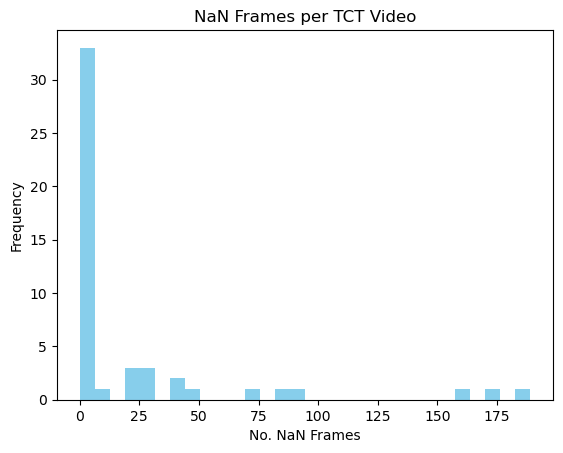

In [1042]:
num_NaNs = np.full(shape = np.sum(pd.notna(controlData["oft_datetime"])), fill_value = 0, dtype=np.float64)
for i in range(len(controlData[pd.notna(controlData["oft_datetime"])]["tct_nanList"])):
    num_NaNs[i] = len(controlData["tct_nanList"][i])

plt.hist(num_NaNs, bins=30, color='skyblue', edgecolor='none')
plt.xlabel('No. NaN Frames')
plt.ylabel('Frequency')
plt.title('NaN Frames per TCT Video')
plt.show()

In [687]:
id = 'B8262'
contourPath = glob.glob(TCT_scored + '*' + id + '*' + 'contours*')
tct = pd.read_csv(contourPath[0], header=0)
addDeltas(tct,"frame_time")
nanIdx, text = nanDetect(tct)
print(id + ': ' + text)

B8262: Total number of NaN frames = 171 (7.124s) 
Total consecutive NaN frames = 149


In [999]:
cmltvReg_Stim = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)
cmltvReg_Center = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)
cmltvReg_Obj = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)

cmltvInt_Stim = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)
cmltvInt_None = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)
cmltvInt_Obj = np.ndarray(shape=len(controlData["ID"]), dtype=np.float64)

for i in range(len(controlData["ID"])):
    contourPath = glob.glob(TCT_scored + '*' + controlData["ID"][i] + '*' + '*contours*')
    if len(contourPath) > 0:
        tct = pd.read_csv(contourPath[0], header=0)
        addDeltas(tct,"frame_time")        
        cmltvLeft_region, cmltvCenter_region, cmltvRight_region, total_time = cmltv_tct(tct, "region", plot=0)
        cmltvLeft_intxn, cmltvNone_intxn, cmltvRight_intxn, total_time = cmltv_tct(tct, "interact", plot=0)

        stim_side = controlData["tct_stimSide"][i]
        if stim_side == 'Left':
            cmltvReg_Stim[i] = cmltvLeft_region[-1]/total_time
            cmltvReg_Center[i] = cmltvCenter_region[-1]/total_time
            cmltvReg_Obj[i] = cmltvRight_region[-1]/total_time
            
            cmltvInt_Stim[i] = cmltvLeft_intxn[-1]/total_time
            cmltvInt_None[i] = cmltvNone_intxn[-1]/total_time
            cmltvInt_Obj[i] = cmltvRight_intxn[-1]/total_time
            
        elif stim_side == 'Right':
            cmltvReg_Stim[i] = cmltvRight_region[-1]/total_time
            cmltvReg_Center[i] = cmltvCenter_region[-1]/total_time
            cmltvReg_Obj[i] = cmltvLeft_region[-1]/total_time
            
            cmltvInt_Stim[i] = cmltvRight_intxn[-1]/total_time
            cmltvInt_None[i] = cmltvNone_intxn[-1]/total_time
            cmltvInt_Obj[i] = cmltvLeft_intxn[-1]/total_time
             
        print(controlData["ID"][i] + ': Stim = ' + str(round(cmltvReg_Stim[i],2)) + '/' + str(round(cmltvInt_Stim[i],2)) + ', Object = ' + str(round(cmltvReg_Obj[i],2)) + '/' + str(round(cmltvInt_Obj[i],2)))
        print('    Region sum = ' + str(round(cmltvReg_Stim[i]+cmltvReg_Obj[i]+cmltvReg_Center[i],5)) + ', Intxn sum = ' + str(round(cmltvInt_Stim[i]+cmltvInt_None[i]+cmltvInt_Obj[i],5)))
        
        for val in [cmltvReg_Stim[i], cmltvReg_Center[i], cmltvReg_Obj[i], cmltvInt_Stim[i], cmltvInt_None[i], cmltvInt_Obj[i]]:
            if val > 1: print('Error: Proportion > 1 detected')
        if cmltvReg_Stim[i]+cmltvReg_Obj[i]+cmltvReg_Center[i] >= 1.01: print('Region sum > 1')
        if cmltvInt_Stim[i]+cmltvInt_None[i]+cmltvInt_Obj[i] >= 1.01: print('Intxn sum > 1')

E0443: Stim = 0.54/0.31, Object = 0.35/0.14
    Region sum = 1.0, Intxn sum = 1.0
E0441: Stim = 0.28/0.17, Object = 0.0/0.0
    Region sum = 1.0, Intxn sum = 1.0
Biggie: Stim = 0.49/0.25, Object = 0.3/0.15
    Region sum = 1.0, Intxn sum = 1.0
LilGuy: Stim = 0.48/0.32, Object = 0.48/0.14
    Region sum = 1.0, Intxn sum = 1.0
B8261: Stim = 0.63/0.4, Object = 0.35/0.22
    Region sum = 1.0, Intxn sum = 1.0
B8262: Stim = 0.65/0.33, Object = 0.24/0.13
    Region sum = 1.0, Intxn sum = 1.0
B8263: Stim = 0.78/0.39, Object = 0.18/0.11
    Region sum = 1.0, Intxn sum = 1.0
B8264: Stim = 0.54/0.28, Object = 0.34/0.15
    Region sum = 1.0, Intxn sum = 1.0
E0437: Stim = 0.32/0.19, Object = 0.52/0.19
    Region sum = 1.0, Intxn sum = 1.0
E0440: Stim = 0.6/0.35, Object = 0.25/0.14
    Region sum = 1.0, Intxn sum = 1.0
E0434: Stim = 0.0/0.0, Object = 0.44/0.0
    Region sum = 1.0, Intxn sum = 1.0
E0435: Stim = 0.71/0.23, Object = 0.05/0.02
    Region sum = 1.0, Intxn sum = 1.0
E0439: Stim = 0.0/0.0,

In [1002]:
controlData.insert(12, 'tct_StimSide', cmltvReg_Stim, False)
controlData.insert(13, 'tct_Center', cmltvReg_Center, False)
controlData.insert(14, 'tct_ObjSide', cmltvReg_Obj, False)
controlData.insert(15, 'tct_StimIntxn', cmltvInt_Stim, False)
controlData.insert(16, 'tct_NoIntxn', cmltvInt_None, False)
controlData.insert(17, 'tct_ObjIntxn', cmltvInt_Obj, False)

controlData.loc[pd.isna(controlData['oft_datetime']),'tct_StimSide'] = np.nan
controlData.loc[pd.isna(controlData['oft_datetime']),'tct_Center'] = np.nan
controlData.loc[pd.isna(controlData['oft_datetime']),'tct_ObjSide'] = np.nan
controlData.loc[pd.isna(controlData['oft_datetime']),'tct_StimIntxn'] = np.nan
controlData.loc[pd.isna(controlData['oft_datetime']),'tct_NoIntxn'] = np.nan
controlData.loc[pd.isna(controlData['oft_datetime']),'tct_ObjIntxn'] = np.nan

In [1003]:
controlData.tail(3)

,ID,Sex,Geno,oft_datetime,oft_nanList,oft_cm_px,oft_Outer,oft_Center,oft_Distance_px,oft_Distance_cm,tct_stimSide,tct_nanList,tct_StimSide,tct_Center,tct_ObjSide,tct_StimIntxn,tct_NoIntxn,tct_ObjIntxn
46,E1203,F,Het,"1/19/24, 1:38 PM",None,0.100684,0.834505,0.165495,121427.478635,12225.810433,Right,"Int64Index([8530, 8531], dtype='int64')",0.358965,0.082760,0.558275,0.185954,0.670712,0.143334
47,E1224,F,WT,"1/19/24, 1:57 PM",None,0.099644,0.786860,0.213140,64392.875652,6416.382165,Left,"Int64Index([], dtype='int64')",0.848605,0.038616,0.112779,0.655638,0.256998,0.087364
48,E1225,M,WT,"1/19/24, 2:16 PM",None,0.101541,0.927708,0.072292,29347.744951,2979.999816,Right,"Int64Index([], dtype='int64')",0.072831,0.126647,0.800523,0.030271,0.836837,0.132892


## Exporting Control Data ##

In [1057]:
controlData.head(2)

,ID,Sex,Geno,oft_datetime,oft_nanList,oft_cm_px,oft_Outer,oft_Center,oft_Distance_px,oft_Distance_cm,tct_stimSide,tct_nanList,tct_StimSide,tct_Center,tct_ObjSide,tct_StimIntxn,tct_NoIntxn,tct_ObjIntxn
0,E0443,M,Het,"9/28/23, 3:03 PM",None,0.101888,0.820503,0.179497,89640.526340,9133.280659,Left,"Int64Index([8988, 8989, 8990, 8991, 8992, 8993...",0.540163,0.113218,0.34662,0.307245,0.550486,0.14227
1,E0441,M,Het,"9/28/23, 3:23 PM",None,0.10197,0.917039,0.082961,45625.481607,4652.428704,Right,"Int64Index([], dtype='int64')",0.276681,0.723319,0.00000,0.167242,0.832758,0.00000


In [1054]:
date.today().strftime("%Y%m%d")
outputPath = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/'
outputName = outputPath + 'controlData_' + date.today().strftime("%Y%m%d") + '.xlsx'
pd.ExcelWriter(outputName)
controlData.to_excel(outputName)

## Plotting ##

In [3]:
controlData_file = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/June2023_ControlBehaviors/controlData_20240123.xlsx'
controlData = pd.read_excel(controlData_file, header=0)
controlData.head(4)

,Unnamed: 0,ID,Sex,Geno,oft_datetime,oft_nanList,oft_cm_px,oft_Outer,oft_Center,oft_Distance_px,oft_Distance_cm,tct_stimSide,tct_nanList,tct_StimSide,tct_Center,tct_ObjSide,tct_StimIntxn,tct_NoIntxn,tct_ObjIntxn
0,0,E0443,M,Het,"9/28/23, 3:03 PM",NaN,0.101888,0.820503,0.179497,89640.526340,9133.280659,Left,"Int64Index([8988, 8989, 8990, 8991, 8992, 8993...",0.540163,0.113218,0.346620,0.307245,0.550486,0.142270
1,1,E0441,M,Het,"9/28/23, 3:23 PM",NaN,0.101970,0.917039,0.082961,45625.481607,4652.428704,Right,"Int64Index([], dtype='int64')",0.276681,0.723319,0.000000,0.167242,0.832758,0.000000
2,2,Biggie,M,WT,"9/28/23, 3:40 PM",NaN,0.101779,0.954746,0.045254,50958.268518,5186.494291,Right,"Int64Index([10621, 10622, 10623, 10624, 10625,...",0.493616,0.207026,0.299357,0.245836,0.606196,0.147968
3,3,LilGuy,M,Het,"9/28/23, 3:54 PM",NaN,0.101927,0.930694,0.069306,111641.395836,11379.257289,Left,"Int64Index([], dtype='int64')",0.483117,0.034962,0.481921,0.322458,0.538657,0.138885


### OFT Data ###

#### Code ####

In [10]:
def testNormal(input, alpha=0.05):

    if len(input) >= 20:
        #This function is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality
        results = scipy.stats.normaltest(input) 
        p_values = results.pvalue
        normal_method = "D'Agostino-Pearson test (combined kurtosis + skewness)"
        if p_value > alpha: isnormal = True
        elif p_value <= alpha: isnormal = False
    else: 
        #For n<20, we have to rely on a Monte Carlo approach to test skew and kurtosis (kurtosistest is only valid n>=20) 
        rvs = lambda size: scipy.stats.norm.rvs(size=size, random_state=np.random.default_rng())
        skew_results = scipy.stats.monte_carlo_test(input, rvs, scipy.stats.skew, vectorized=True)
        kurtosis_results = scipy.stats.monte_carlo_test(input, rvs, scipy.stats.kurtosis, vectorized=True)
        p_values = [skew_results.pvalue, kurtosis_results.pvalue]
        normal_method = "Monte Carlo method (Fisher kurtosis + Fisher-Pearson skewness)"
        # data is only treated as normal if it has both normal skew and kurtosis
        if p_values[0] > 0.05 and p_values[1] > alpha: isnormal = True
        else: isnormal = False

    return isnormal, p_values, normal_method

In [8]:
def oft_StatGraph(data_df, sex, na_column = "oft_datetime", plot_column = 'oft_Outer', show_plot=True, print_ps = True, show_ps = True, print_means = False, saveFig = False, figName = 'oftGraph.png', savePath = ''):
    # e.g. oft_StatGraph(controlData, 'M')

    #### Setting basic parameters based on inputs ####
    if plot_column == 'oft_Outer': 
        region_word = 'Outer Region'
    elif plot_column == 'oft_Center': 
        region_word = 'Center Region'

    #### Separating wt and het data from target sex ####
    df_wt = pd.DataFrame({'regionTime': data_df[(data_df['Sex']==sex) & (data_df['Geno']=='WT') & (pd.notna(data_df[na_column]))][plot_column]})
    df_wt = df_wt.reset_index(drop=True)
    df_het = pd.DataFrame({'regionTime': data_df[(data_df['Sex']==sex) & (data_df['Geno']=='Het') & (pd.notna(data_df[na_column]))][plot_column]})
    df_het = df_het.reset_index(drop=True)
    
    #### Setting color schemes and labels based on sex ####
    # set color scheme and label keywords by sex
    if sex == 'M': 
        sex_word = 'Male'
        light_col1 = 'lightblue'
        light_col2 = 'xkcd:lightblue'
        dark_col1 = 'navy'
        dark_col2 = 'xkcd:navy'
    elif sex == 'F': 
        sex_word = 'Female'
        light_col1 = 'lightcoral'
        light_col2 = 'tomato'
        dark_col1 = 'brown'
        dark_col2 = 'xkcd:crimson'
    
    #### Stats ####
    #### Testing for normality via skew and kurtosis (normaltest for n>=20, monte carlo for n<20) ####
    wt_norm = testNormal(df_wt['regionTime'])[0]
    het_norm = testNormal(df_het['regionTime'])[0]
    normal_test = [wt_norm, het_norm]

    #### tests against 0.50 null: t-test or wilcoxon ####
    if wt_norm == True:
        wt_res = scipy.stats.ttest_1samp(df_wt['regionTime'], popmean = 0.5)
        wt_p = wt_res.pvalue
        wt_test = '1-sample t-test, null = 0.50'
    else:     
        wt_stat, wt_p = scipy.stats.wilcoxon(df_wt['regionTime'] - 0.5, zero_method = 'pratt')
        wt_test = 'wilcoxon signed-rank test'
    
    if het_norm == True:
        het_res = scipy.stats.ttest_1samp(df_het['regionTime'], popmean=0.5)
        het_p = het_res.pvalue
        het_test = '1-sample t-test, null = 0.50'
    else:     
        het_stat, het_p = scipy.stats.wilcoxon(df_het['regionTime'] - 0.5, zero_method = 'pratt')
        het_test = 'wilcoxon signed-rank test'  
        
    #### independent tests: t-test or mann-whitney ####
    if wt_norm == True and het_norm == True: 
        region_stat, region_p = scipy.stats.ttest_ind(df_wt['regionTime'], df_het['regionTime'])
        region_test = 'independent samples t-test'
    else: 
        region_stat, region_p = scipy.stats.mannwhitneyu(df_wt['regionTime'], df_het['regionTime']) 
        region_test = 'mann-whitney u test'

    ps = [wt_p, het_p, region_p]
    p_statements = [('WT Time in ' + region_word + ' vs 0.5:'),('Het Time in ' + region_word + ' vs 0.5:'),('WT vs Het Time in ' + region_word + ':')]
    stat_tests = [wt_test, het_test, region_test]
    
    #### Plotting ####
    if show_plot == True:
        
        # make dfs for jittered x-values (made of random numbers around +/-0.05) with same same column labels as original df
        jitter = 0.05
        df_wt_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df_wt.values.shape), columns=df_wt.columns)
        df_wt_jitter += 0 # wt columns are jittered around 0 
        df_het_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df_het.values.shape), columns=df_het.columns)
        df_het_jitter += 1 # het columns are jittered around 1
   
        # Plot points and bars for wt and het dfs with appropriate colors and labels
        fig, ax = plt.subplots()
        ax.plot(df_wt_jitter['regionTime'], df_wt['regionTime'], 'o', markerfacecolor=dark_col2 , markeredgecolor =dark_col2,zorder=1, ms=5, mew=1)
        ax.bar(0, np.mean(df_wt['regionTime']), color = dark_col1, edgecolor = 'none', yerr = scipy.stats.sem(df_wt['regionTime']), ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5)
        ax.plot(df_het_jitter['regionTime'], df_het['regionTime'], 'o', markerfacecolor=light_col2 , markeredgecolor =light_col2,zorder=1, ms=5, mew=1)
        ax.bar(1, np.mean(df_het['regionTime']), color = light_col1, edgecolor = 'none', yerr = scipy.stats.sem(df_wt['regionTime']), ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5)
        ax.axhline(y=0.5, color='k', linestyle='--',zorder=1)
        ax.set_xticks([0, 1]) 
        ax.set_xticklabels([' WT',' Het']) # labels 0-3 with appropriate column name
        ax.set_xlim(-0.5,1.5) # set x limits to column +/- 0.5
        ax.set_yticks([0, 0.2,0.4,0.6,0.8,1]) #ticks on each integer
        ax.set_ylim(0,1.15) # set y limits
        ax.set_ylabel('Proportion of assay')
        ax.set_xlabel('Scn2a X1 Genotype')
        ax.set_title((sex_word + ' OFT ' + region_word))
        fig.set_figwidth(4)
        
        # Make p-labels
        p_labels = ['label0', 'label1', 'label2']
        for i in range(len(ps)):   
            if ps[i] < 0.01: 
                p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
                if ps[i]< 0.001: p_label = '***'
                else: p_label = '**'
            elif ps[i] >= 0.01: 
                p_formatted = str(round(ps[i], 3))
                if ps[i]<=0.05: p_label = '*'
                else: p_label = 'n.s.'
            p_labels[i] = p_label
            if print_ps == True: print(sex_word + ' ' + p_statements[i] +' p = ' + p_formatted + ', ' + stat_tests[i])
        
        # Define p-value bar values
        p_color = ['color0', 'color1', 'color2']
        for p_val, i in zip(ps,[0,1,2]):
            if p_val>=0.05: p_color[i] = 'lightgray'
            elif p_val<0.05: p_color[i] = 'k'
        if np.max([np.max(df_wt['regionTime']),np.max(df_het['regionTime'])]) >= 0.94: y_bar = 1.0
        else: y_bar = np.max([np.max(df_wt['regionTime']),np.max(df_het['regionTime'])]) + 0.06 
        
        
        if show_ps == True:
            # Plot p-labels
            ax.text(0, y_bar+0.01, p_labels[0], fontsize=10, ha='center',color = p_color[0])
            ax.text(1, y_bar+0.01, p_labels[1], fontsize=10, ha='center',color = p_color[1])
            ax.plot([0,1],[y_bar+0.07,y_bar+0.07],color = p_color[2], linewidth = 1, linestyle = '-', zorder=1)
            ax.text(0.5, y_bar+0.09, p_labels[2], fontsize=10, ha='center',color = p_color[2])
            
        if saveFig == True: plt.savefig((savePath + figName))
        plt.show()
        
    means = [np.mean(df_wt['regionTime']), np.mean(df_het['regionTime'])]
    sems = [scipy.stats.sem(df_wt['regionTime']), scipy.stats.sem(df_het['regionTime'])]
    if print_means == True: 
        print('WT' + sex_word + ' ' + region_word + ' = ' + str(round(means[0], 2)) + '±' + str(round(sems[0], 2)))
        print('Het' + sex_word + ' ' + region_word + ' = ' + str(round(means[1], 2)) + '±' + str(round(sems[1], 2)))

    return means, sems, ps, p_statements, stat_tests, normal_test

In [6]:
def oft_DistanceGraph(data_df, sex, na_column = "oft_datetime", units='cm', show_plot=True, print_ps = True, show_ps = True, print_means = False, saveFig = False, figName = 'tctGraph.png', savePath = ''):
    # e.g. oft_DistanceGraph(controlData, 'M')

    #### Separating wt and het data from target sex ####
    df_wt = pd.DataFrame({'distance_px': data_df[(data_df['Sex']==sex) & (data_df['Geno']=='WT') & (pd.notna(data_df[na_column]))]["oft_Distance_px"],
                         'distance_cm':  data_df[(data_df['Sex']==sex) & (data_df['Geno']=='WT') & (pd.notna(data_df[na_column]))]["oft_Distance_cm"]})
    df_wt = df_wt.reset_index(drop=True)
    df_het = pd.DataFrame({'distance_px': data_df[(data_df['Sex']==sex) & (data_df['Geno']=='Het') & (pd.notna(data_df[na_column]))]["oft_Distance_px"],
                         'distance_cm':  data_df[(data_df['Sex']==sex) & (data_df['Geno']=='Het') & (pd.notna(data_df[na_column]))]["oft_Distance_cm"]})
    df_het = df_het.reset_index(drop=True)
   
    #### Setting basic parameters based on inputs ####
    if units == 'cm': data_col = 'distance_cm'
    elif units == 'px' or units == 'pixels': data_col = 'distance_px'
    if sex == 'M': 
        sex_word = 'Male'
        light_col1 = 'lightblue'
        light_col2 = 'xkcd:lightblue'
        dark_col1 = 'navy'
        dark_col2 = 'xkcd:navy'
    elif sex == 'F': 
        sex_word = 'Female'
        light_col1 = 'lightcoral'
        light_col2 = 'tomato'
        dark_col1 = 'brown'
        dark_col2 = 'xkcd:crimson'
    
    #### Stats ####
    #### Testing for normality via skew and kurtosis (normaltest for n>=20, monte carlo for n<20) ####
    wt_norm = testNormal(df_wt[data_col])[0]
    het_norm = testNormal(df_het[data_col])[0]
    normal_test = [wt_norm, het_norm]

    #### independent tests: t-test or mann-whitney ####
    if wt_norm == True and het_norm == True: 
        distance_stat, distance_p = scipy.stats.ttest_ind(df_wt[data_col], df_het[data_col])
        distance_test = 'independent samples t-test'
    else: 
        distance_stat, distance_p = scipy.stats.mannwhitneyu(df_wt[data_col], df_het[data_col]) 
        distance_test = 'mann-whitney u test'

    ps = [distance_p]
    p_statements = [('WT vs Het Distance (' + units + '):')]
    stat_tests = [distance_test]
    
    #### Plotting ####
    if show_plot == True:
        
        # make dfs for jittered x-values (made of random numbers around +/-0.05) with same same column labels as original df
        jitter = 0.05
        df_wt_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df_wt.values.shape), columns=df_wt.columns)
        df_wt_jitter += 0 # wt columns are jittered around 0 
        df_het_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df_het.values.shape), columns=df_het.columns)
        df_het_jitter += 1 # het columns are jittered around 1
   
        # Plot points and bars for wt and het dfs with appropriate colors and labels
        fig, ax = plt.subplots()
        ax.plot(df_wt_jitter[data_col], df_wt[data_col], 'o', markerfacecolor=dark_col2 , markeredgecolor =dark_col2,zorder=1, ms=5, mew=1)
        ax.bar(0, np.mean(df_wt[data_col]), color = dark_col1, edgecolor = 'none', yerr = scipy.stats.sem(df_wt[data_col]), ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5)
        ax.plot(df_het_jitter[data_col], df_het[data_col], 'o', markerfacecolor=light_col2 , markeredgecolor =light_col2,zorder=1, ms=5, mew=1)
        ax.bar(1, np.mean(df_het[data_col]), color = light_col1, edgecolor = 'none', yerr = scipy.stats.sem(df_wt[data_col]), ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5)
        ax.set_xticks([0, 1]) 
        ax.set_xticklabels([' WT',' Het']) # labels 0-3 with appropriate column name
        ax.set_xlim(-0.5,1.5) # set x limits to column +/- 0.5
        ax.set_ylabel(('Distance traveled (' + units + ')'))
        ax.set_xlabel('Scn2a X1 Genotype')
        ax.set_ylim(0,13500) # set y limits
        ax.set_title((sex_word + ' Locomotion in OFT'))
        fig.set_figwidth(4)
        
        # Make p-labels
        p_labels = ['label0']
        for i in range(len(ps)):   
            if ps[i] < 0.01: 
                p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
                if ps[i]< 0.001: p_label = '***'
                else: p_label = '**'
            elif ps[i] >= 0.01: 
                p_formatted = str(round(ps[i], 3))
                if ps[i]<=0.05: p_label = '*'
                else: p_label = 'n.s.'
            p_labels[i] = p_label
            if print_ps == True: print(sex_word + ' ' + p_statements[i] + side_or_intxn_word.lower() + ': p = ' + p_formatted + ', ' + stat_tests[i])
        
        # Define p-value bar values
        p_color = ['color0']
        for p_val, i in zip(ps,[0]):
            if p_val>=0.05: p_color[i] = 'lightgray'
            elif p_val<0.05: p_color[i] = 'k'
        if np.max([np.max(df_wt[data_col]),np.max(df_het[data_col])]) >= 12000: y_bar = 12500
        else: y_bar = np.max([np.max(df_wt[data_col]),np.max(df_het[data_col])]) + 500 
        
        
        if show_ps == True:
            # Plot p-labels
            ax.plot([0,1],[y_bar+100,y_bar+100],color = p_color[0], linewidth = 1, linestyle = '-', zorder=1)
            ax.text(0.5, y_bar+200, p_labels[0], fontsize=10, ha='center',color = p_color[0])
            
        if saveFig == True: plt.savefig((savePath + figName))
        plt.show()
        
    means = [np.mean(df_wt[data_col]), np.mean(df_het[data_col])]
    sems = [scipy.stats.sem(df_wt[data_col]), scipy.stats.sem(df_het[data_col])]
    if print_means == True: 
        print('WT' + sex_word + ' Distance (' + units + ') = ' + str(round(means[0], 2)) + '±' + str(round(sems[0], 2)))
        print('Het' + sex_word + ' Distance (' + units + ') = ' + str(round(means[1], 2)) + '±' + str(round(sems[1], 2)))

    return means, sems, ps, p_statements, stat_tests, normal_test

In [1474]:
def oft_StatGraph_old(data, na_column, sex, show_plot=True, show_means=True, show_ps=True, saveFig = False, figName = 'oftGraph.png', savePath = ''):
    # e.g. oft_StatGraph(controlData, "oft_datetime", 'M')
    #filter data by sex, restructure df so it works with seaborn
    sexData = data[pd.notna(data[na_column]) & (data["Sex"] == sex)]
    
    d_outer = {'ID': sexData["ID"], 'Sex': sexData["Sex"],'Geno': sexData["Geno"], 'region': np.full(len(sexData),"outer"), 'regionTime': sexData["oft_Outer"]}
    outerDF = pd.DataFrame(data = d_outer)
    outerDF = outerDF.reset_index(drop=True)
    
    d_center = {'ID': sexData["ID"], 'Sex': sexData["Sex"],'Geno': sexData["Geno"], 'region': np.full(len(sexData),"center"), 'regionTime': sexData["oft_Center"]}
    centerDF = pd.DataFrame(data = d_center)
    centerDF = centerDF.reset_index(drop=True)
   
    sex_OFT = pd.concat([outerDF, centerDF], axis=0, join='outer', ignore_index=True)
    
    if sex == 'M': 
        sex_word = 'Male'
        light_col1 = 'lightblue'
        light_col2 = 'xkcd:lightblue'
        dark_col1 = 'navy'
        dark_col2 = 'xkcd:navy'
        
    elif sex == 'F': 
        sex_word = 'Female'
        light_col1 = 'salmon'
        light_col2 = 'xkcd:coral'
        dark_col1 = 'brown'
        dark_col2 = 'xkcd:crimson'
    
    if show_plot == True:
        sns.barplot(data=sex_OFT, x="Geno", y="regionTime", order = ['WT', 'Het'], hue="region", palette = [dark_col1,light_col1],width=0.8,alpha = 0.5, errorbar = 'se')
        sns.swarmplot(data=sex_OFT, x="Geno", y="regionTime", order = ['WT', 'Het'], hue="region", palette = [dark_col2,light_col2], dodge=True, legend = False)
        plt.ylabel('time in region (s)')
        plt.xlabel('Scn2a X1 Genotype')
        plt.title((sex_word + ' OFT Regions'))
        
        if saveFig == True: plt.savefig((savePath + figName))
        plt.show()
            
    means = np.ndarray(4, dtype=np.float64)
    sems = np.ndarray(4, dtype=np.float64)
    i = 0
    for g in ['WT', 'Het']:
        for r in ['outer','center']:
            mean, sem = regionMeans_by_geno(sex_OFT, r, g)
            means[i] = mean
            sems[i] = sem
            if show_means == True: print(g + ' ' + sex_word + ' duration in ' + r + ' region = ' + str(round(mean, 2)) + '±' + str(round(sem, 2))+' sec')
            i =+ 1
    
    wt_t, wt_p = scipy.stats.ttest_rel(sex_OFT[(sex_OFT["Geno"]=="WT") & (sex_OFT["region"]=="outer")]["regionTime"], sex_OFT[(sex_OFT["Geno"]=="WT") & (sex_OFT["region"]=="center")]["regionTime"])
    het_t, het_p = scipy.stats.ttest_rel(sex_OFT[(sex_OFT["Geno"]=="Het") & (sex_OFT["region"]=="outer")]["regionTime"], sex_OFT[(sex_OFT["Geno"]=="Het") & (sex_OFT["region"]=="center")]["regionTime"])

    outer_t, outer_p = scipy.stats.ttest_ind(sex_OFT[(sex_OFT["Geno"]=="WT") & (sex_OFT["region"]=="outer")]["regionTime"], sex_OFT[(sex_OFT["Geno"]=="Het") & (sex_OFT["region"]=="outer")]["regionTime"])
    center_t, center_p = scipy.stats.ttest_ind(sex_OFT[(sex_OFT["Geno"]=="WT") & (sex_OFT["region"]=="center")]["regionTime"], sex_OFT[(sex_OFT["Geno"]=="Het") & (sex_OFT["region"]=="center")]["regionTime"])

    ps = [wt_p, het_p, outer_p, center_p]
    p_statements = ['WT Outer vs Center:','Het Outer vs Center:', 'WT vs Het Outer:', 'WT vs Het Center:']
    
    #####ADD A FUNCTION TO DO DIFFERENT STATS BASED ON NORMALITY########
    if show_ps == True:
        for i in range(len(ps)):
            if ps[i] < 0.01:
                p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
            elif ps[i] >= 0.01:
                p_formatted = str(round(ps[i], 3))
            print(sex_word + ' ' + p_statements[i] + ' p = ' + p_formatted)
    
    return sex_OFT, means, sems, ps, p_statements
    

#### Graphs ####

Male WT Time in Outer Region vs 0.5: p = 1.755e-09, 1-sample t-test, null = 0.50
Male Het Time in Outer Region vs 0.5: p = 1.273e-09, 1-sample t-test, null = 0.50
Male WT vs Het Time in Outer Region: p = 0.357, independent samples t-test


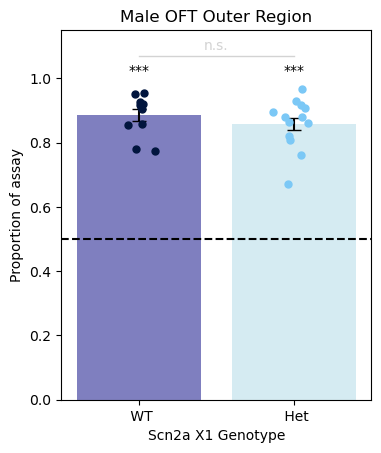

In [11]:
m_oft_region = oft_StatGraph(controlData, 'M',saveFig=True, figName = 'maleOFT_region.png')

Female WT Time in Outer Region vs 0.5: p = 2.001e-11, 1-sample t-test, null = 0.50
Female Het Time in Outer Region vs 0.5: p = 3.593e-12, 1-sample t-test, null = 0.50
Female WT vs Het Time in Outer Region: p = 0.468, independent samples t-test


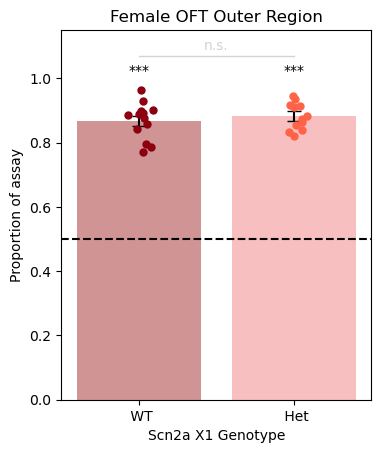

In [1566]:
f_oft = oft_StatGraph(controlData, 'F',saveFig=True, figName = 'femaleOFT_region.png')

Male WT vs Het Distance (cm):interaction time: p = 0.611, independent samples t-test


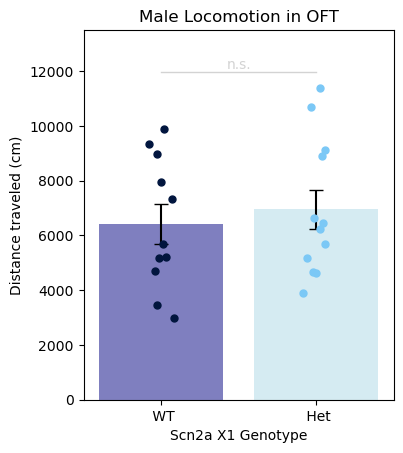

In [1530]:
m_distance = oft_DistanceGraph(controlData, 'M',saveFig = True, figName = 'maleOFT_locomotion.png')

Female WT vs Het Distance (cm):interaction time: p = 0.519, independent samples t-test


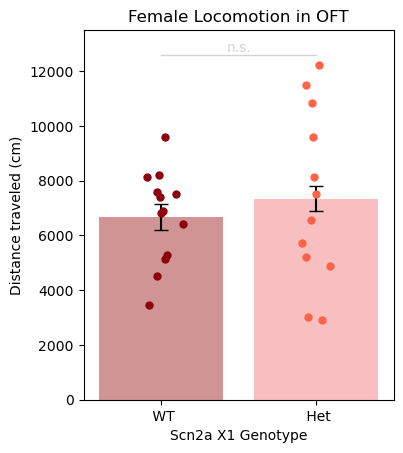

In [1531]:
f_distance = oft_DistanceGraph(controlData, 'F',saveFig = True, figName = 'femaleOFT_locomotion.png')

### TCT Data ###

#### Code ####

In [1648]:
def tct_StatGraph(data_df, sex, side_or_intxn, na_column = "oft_datetime", mode = 'paired', show_plot=True, print_ps = True, show_ps = True, print_means = False, saveFig = False, figName = 'tctGraph.png', savePath = ''):
    # e.g. tct_StatGraph(controlData, 'M', 'side')
    
    #### Setting basic parameters based on inputs ####
    if side_or_intxn == 'side': 
        stim_column = 'tct_StimSide'
        obj_column = 'tct_ObjSide' 
        side_or_intxn_word = 'Chamber Time'
        side_or_intxn_idx_word = 'Chamber'
    elif side_or_intxn == 'intxn' or side_or_intxn == 'interact' or side_or_intxn == 'interaction':
        stim_column = 'tct_StimIntxn'
        obj_column = 'tct_ObjIntxn'
        side_or_intxn_word = 'Interaction Time'
        side_or_intxn_idx_word = 'Interaction'


    #### Separating wt and het data from target sex into separate dataframes ####
    df_wt = pd.DataFrame({'Animal': data_df[(data_df['Sex']==sex) & (data_df['Geno']=='WT') & (pd.notna(data_df[na_column]))][stim_column],
                   'Object': data_df[(data_df['Sex']==sex) & (data_df['Geno']=='WT') & (pd.notna(data_df[na_column]))][obj_column]})
    df_wt = df_wt.reset_index(drop=True)
    df_het = pd.DataFrame({'Animal': data_df[(data_df['Sex']==sex) & (data_df['Geno']=='Het') & (pd.notna(data_df[na_column]))][stim_column],
                       'Object': data_df[(data_df['Sex']==sex) & (data_df['Geno']=='Het') & (pd.notna(data_df[na_column]))][obj_column]})
    df_het = df_het.reset_index(drop=True)

    #### Setting color schemes and labels based on sex ####
    # set color scheme and label keywords by sex
    if sex == 'M': 
        sex_word = 'Male'
        light_col1 = 'lightblue'
        light_col2 = 'xkcd:lightblue'
        dark_col1 = 'navy'
        dark_col2 = 'xkcd:navy'
    elif sex == 'F': 
        sex_word = 'Female'
        light_col1 = 'lightcoral'
        light_col2 = 'tomato'
        dark_col1 = 'brown'
        dark_col2 = 'xkcd:crimson'
    
    if mode == 'paired': ### Four column situation with lines
        #### Setting basic parameters based on inputs ####
        if side_or_intxn == 'side': y_max = 1.3
        elif side_or_intxn == 'intxn' or side_or_intxn == 'interact' or side_or_intxn == 'interaction': y_max = 1.15

        #### Stats ####
        #### Testing for normality via skew and kurtosis (normaltest for n>=20, monte carlo for n<20) ####
        wt_animal_norm = testNormal(df_wt['Animal'])[0]
        wt_object_norm = testNormal(df_wt['Object'])[0]
        het_animal_norm = testNormal(df_het['Animal'])[0]
        het_object_norm = testNormal(df_het['Object'])[0]
        normal_test = [wt_animal_norm, wt_object_norm, het_animal_norm, het_object_norm]

        #### paired tests: paired-t-test, wilcoxon signed-rank ####
        if wt_animal_norm == True and wt_object_norm == True: 
            wt_stat, wt_p = scipy.stats.ttest_rel(df_wt['Animal'], df_wt['Object'])
            wt_test = 'paired t-test'
        else: 
            wt_stat, wt_p = scipy.stats.wilcoxon(df_wt['Animal'] - df_wt['Object'], zero_method = 'pratt')
            wt_test = 'wilcoxon signed-rank test'
        if het_animal_norm == True and het_object_norm == True: 
            het_stat, het_p = scipy.stats.ttest_rel(df_het['Animal'], df_het['Object'])
            het_test = 'paired t-test'
        else: 
            het_stat, het_p = scipy.stats.wilcoxon(df_het['Animal'] - df_het['Object'], zero_method = 'pratt')
            het_test = 'wilcoxon signed-rank test'
        #### independent tests: t-test or mann-whitney ####
        if wt_animal_norm == True and het_animal_norm == True: 
            stim_stat, stim_p = scipy.stats.ttest_ind(df_wt['Animal'], df_het['Animal'])
            stim_test = 'independent samples t-test'
        else: 
            stim_stat, stim_p = scipy.stats.mannwhitneyu(df_wt['Animal'], df_het['Animal']) 
            stim_test = 'mann-whitney u test'

        if wt_object_norm == True and het_object_norm == True: 
            obj_stat, obj_p = scipy.stats.ttest_ind(df_wt['Object'], df_het['Object'])
            obj_test = 'independent samples t-test'
        else: 
            obj_stat, obj_p = scipy.stats.mannwhitneyu(df_wt['Object'], df_het['Object'])
            obj_test = 'mann-whitney u test'
        ps = [wt_p, het_p, stim_p, obj_p]
        p_statements = ['WT animal vs object ','Het animal vs object ', 'WT vs Het animal ', 'WT vs Het object ']
        stat_tests = [wt_test, het_test, stim_test, obj_test]

        #### Plotting ####
        if show_plot == True:

            # make dfs for jittered x-values (made of random numbers around +/-0.05) with same same column labels as original df
            jitter = 0.05
            df_wt_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df_wt.values.shape), columns=df_wt.columns)
            df_wt_jitter += [0,1] # wt columns are jittered around 0 and 1 (animal and object, respectively)
            df_het_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df_het.values.shape), columns=df_het.columns)
            df_het_jitter += [2,3] # het columns are jittered around 2 and 3 (animal and object, respectively)

            # Plot points and bars for wt and het dfs with appropriate colors and labels
            fig, ax = plt.subplots()
            for df, df_jitter, bar_color, mkr_color, animal_x, animal_alpha, label_mod in zip([df_wt,df_het],[df_wt_jitter,df_het_jitter],[dark_col1, light_col1],[dark_col2, light_col2],[0,2],[0.5,0.7],['','_']):
                ax.plot(df_jitter['Animal'], df['Animal'], 'o', markerfacecolor=mkr_color , markeredgecolor =mkr_color,zorder=1, ms=5, mew=1)
                ax.bar(animal_x, np.mean(df['Animal']), color = bar_color, edgecolor = 'none', yerr = scipy.stats.sem(df['Animal']), ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = animal_alpha, label=(label_mod+'Animal'))
                ax.plot(df_jitter['Object'], df['Object'], 'o', markerfacecolor='none' , markeredgecolor =mkr_color,zorder=1, ms=5, mew=1)
                ax.bar(animal_x+1, np.mean(df['Object']), color = 'none', edgecolor = bar_color, yerr = scipy.stats.sem(df['Object']), ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = 1, label=(label_mod+'Object'))
            ax.set_xticks([0.5, 2.5]) 
            ax.set_xticklabels([' WT',' Het']) # labels 0-3 with appropriate column name
            ax.set_xlim(-0.5,3.5) # set x limits to column +/- 0.5
            ax.set_yticks([0, 0.2,0.4,0.6,0.8,1]) #ticks on each integer
            ax.set_ylim(0,y_max) # set y limits
            ax.set_ylabel('Proportion of assay')
            ax.set_xlabel('Scn2a X1 Genotype')
            ax.set_title((sex_word + ' TCT ' + side_or_intxn_word))
            ax.legend()
            fig.set_figwidth(7)

            # Plot connecting lines
            for idx in df_wt.index: ax.plot(df_wt_jitter.loc[idx,['Animal','Object']], df_wt.loc[idx,['Animal','Object']], color = 'k', linewidth = 0.5, linestyle = '-', zorder=-1)
            for idx in df_het.index: ax.plot(df_het_jitter.loc[idx,['Animal','Object']], df_het.loc[idx,['Animal','Object']], color = 'k', linewidth = 0.5, linestyle = '-', zorder=-1)

            # Make p-labels
            p_labels = ['label0','label1','label2','label3']
            for i in range(len(ps)):   
                if ps[i] < 0.01: 
                    p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
                    if ps[i]< 0.001: p_label = '***'
                    else: p_label = '**'
                elif ps[i] >= 0.01: 
                    p_formatted = str(round(ps[i], 3))
                    if ps[i]<=0.05: p_label = '*'
                    else: p_label = 'n.s.'
                p_labels[i] = p_label
                if print_ps == True: print(sex_word + ' ' + p_statements[i] + side_or_intxn_word.lower() + ': p = ' + p_formatted + ', ' + stat_tests[i])

            # Define p-value bar values
            p_color = ['color0','color1','color2','color3']
            for p_val, i in zip(ps,[0,1,2,3]):
                if p_val>=0.05: p_color[i] = 'lightgray'
                elif p_val<0.05: p_color[i] = 'k'
            if np.max([np.max(df_wt['Animal']),np.max(df_wt['Object'])]) >= 0.89: wt_y_bar = 1.01
            else: wt_y_bar = np.max([np.max(df_wt['Animal']),np.max(df_wt['Object'])]) + 0.12 
            if np.max([np.max(df_het['Animal']),np.max(df_het['Object'])]) >= 0.89: het_y_bar = 1.01
            else: het_y_bar = np.max([np.max(df_het['Animal']),np.max(df_het['Object'])]) + 0.12

            if show_ps == True:
                # Plot p-labels
                ax.plot([0,1],[np.max([wt_y_bar,het_y_bar])+0.01,np.max([wt_y_bar,het_y_bar])+0.01],color = p_color[0], linewidth = 1, linestyle = '-', zorder=1)
                ax.text(0.5, np.max([wt_y_bar,het_y_bar])+0.02, p_labels[0], fontsize=10,ha='center',color = p_color[0])
                ax.plot([2,3],[np.max([wt_y_bar,het_y_bar])+0.01,np.max([wt_y_bar,het_y_bar])+0.01],color = p_color[1], linewidth = 1, linestyle = '-', zorder=1)   
                ax.text(2.5, np.max([wt_y_bar,het_y_bar])+0.02, p_labels[1], fontsize=10,ha='center',color = p_color[1])
                ax.plot([0,2],[np.max([wt_y_bar,het_y_bar])+0.1,np.max([wt_y_bar,het_y_bar])+0.1],color = p_color[2], linewidth = 1, linestyle = '-', zorder=1)   
                ax.text(1, np.max([wt_y_bar,het_y_bar])+0.11, p_labels[2], fontsize=10,ha='center',color = p_color[2])
                ax.plot([1,3],[np.max([wt_y_bar,het_y_bar])+0.2,np.max([wt_y_bar,het_y_bar])+0.2],color = p_color[3], linewidth = 1, linestyle = '-', zorder=1)   
                ax.text(2, np.max([wt_y_bar,het_y_bar])+0.21, p_labels[3], fontsize=10,ha='center',color = p_color[3])

            if saveFig == True: plt.savefig((savePath + figName))
            plt.show() 

        means = [np.mean(df_wt['Animal']), np.mean(df_wt['Object']), np.mean(df_het['Animal']), np.mean(df_het['Object'])]
        sems = [scipy.stats.sem(df_wt['Animal']), scipy.stats.sem(df_wt['Object']), scipy.stats.sem(df_het['Animal']), scipy.stats.sem(df_het['Object'])]
        if print_means == True: 
            print('WT' + ' ' + sex_word + ' ' + 'animal' + ' ' +side_or_intxn_word.lower() + ' = ' + str(round(means[0], 2)) + '±' + str(round(sems[0], 2)))
            print('WT' + ' ' + sex_word + ' ' + 'object' + ' ' +side_or_intxn_word.lower() + ' = ' + str(round(means[1], 2)) + '±' + str(round(sems[1], 2)))
            print('Het' + ' ' + sex_word + ' ' + 'animal' + ' ' +side_or_intxn_word.lower() + ' = ' + str(round(means[2], 2)) + '±' + str(round(sems[2], 2)))
            print('Het' + ' ' + sex_word + ' ' + 'object' + ' ' +side_or_intxn_word.lower() + ' = ' + str(round(means[3], 2)) + '±' + str(round(sems[3], 2)))
    
    elif mode == 'index' or mode == 'idx' or mode == 'Index':
        
        wt_preference_index = np.ndarray(len(df_wt), dtype=np.float64)
        for idx in df_wt.index: wt_preference_index[idx] = preferenceIndex(df_wt['Animal'][idx], df_wt['Object'][idx])
        het_preference_index = np.ndarray(len(df_het), dtype=np.float64)
        for idx in df_het.index: het_preference_index[idx] = preferenceIndex(df_het['Animal'][idx], df_het['Object'][idx])
    
        prefIndex_wt = pd.DataFrame({'prefIndex': wt_preference_index})
        prefIndex_het = pd.DataFrame({'prefIndex': het_preference_index})

        # normality test
        wt_pi_norm = testNormal(prefIndex_wt['prefIndex'])[0]
        het_pi_norm = testNormal(prefIndex_het['prefIndex'])[0]
        normal_test = [wt_pi_norm, het_pi_norm]

        #### tests against 0 null: t-test or wilcoxon ####
        if wt_pi_norm == True:
            wt_res = scipy.stats.ttest_1samp(prefIndex_wt['prefIndex'], popmean = 0)
            wt_p = wt_res.pvalue
            wt_test = '1-sample t-test, null = 0'
        else:     
            wt_stat, wt_p = scipy.stats.wilcoxon(prefIndex_wt['prefIndex'], zero_method = 'pratt')
            wt_test = 'wilcoxon signed-rank test'
        if het_pi_norm == True:
            het_res = scipy.stats.ttest_1samp(prefIndex_het['prefIndex'], popmean = 0)
            het_p = het_res.pvalue
            het_test = '1-sample t-test, null = 0'
        else:     
            het_stat, het_p = scipy.stats.wilcoxon(prefIndex_het['prefIndex'], zero_method = 'pratt')
            het_test = 'wilcoxon signed-rank test'  

        #### independent tests: t-test or mann-whitney ####
        if wt_pi_norm == True and het_pi_norm == True: 
            prefIdx_stat, prefIdx_p = scipy.stats.ttest_ind(prefIndex_wt['prefIndex'], prefIndex_het['prefIndex'])
            prefIdx_test = 'independent samples t-test'
        else: 
            prefIdx_stat, prefIdx_p = scipy.stats.mannwhitneyu(prefIndex_wt['prefIndex'], prefIndex_het['prefIndex']) 
            prefIdx_test = 'mann-whitney u test'   

        ps = [wt_p, het_p, prefIdx_p]
        p_statements = [('WT '+side_or_intxn_idx_word+' Index vs 0:'),('Het '+side_or_intxn_idx_word+' Index vs 0:'),('WT vs Het '+side_or_intxn_idx_word+' Index:')]
        stat_tests = [wt_test, het_test, prefIdx_test]
        
        if show_plot == True: 
            
            jitter = 0.05
            df_wt_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=prefIndex_wt.values.shape), columns=prefIndex_wt.columns)
            df_wt_jitter += 0 # wt columns are jittered around 0 
            df_het_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=prefIndex_het.values.shape), columns=prefIndex_het.columns)
            df_het_jitter += 1 # het columns are jittered around 1

            # Plot points and bars for wt and het dfs with appropriate colors and labels
            fig, ax = plt.subplots()
            ax.plot(df_wt_jitter['prefIndex'], prefIndex_wt['prefIndex'], 'o', markerfacecolor=dark_col2 , markeredgecolor =dark_col2,zorder=1, ms=5, mew=1)
            ax.bar(0, np.mean(prefIndex_wt['prefIndex']), color = dark_col1, edgecolor = 'none', yerr = scipy.stats.sem(prefIndex_wt['prefIndex']), ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = 0.5)
            ax.plot(df_het_jitter['prefIndex'], prefIndex_het['prefIndex'], 'o', markerfacecolor=light_col2 , markeredgecolor =light_col2,zorder=1, ms=5, mew=1)
            ax.bar(1, np.mean(prefIndex_het['prefIndex']), color = light_col1, edgecolor = 'none', yerr = scipy.stats.sem(prefIndex_het['prefIndex']), ecolor = 'k', capsize = 5,linewidth = 1, zorder=-1, alpha = 0.7)
            ax.axhline(y=0, color='k', linestyle='-',zorder=1)
            ax.set_xticks([0, 1]) 
            ax.set_xticklabels([' WT',' Het']) 
            ax.set_xlim(-0.5,1.5) # set x limits to column +/- 0.5
            ax.set_ylabel('Preference Index')
            ax.set_xlabel('Scn2a X1 Genotype')
            ax.set_ylim(-1.2,1.2) # set y limits
            ax.set_title((sex_word + ' ' +side_or_intxn_idx_word+  ' Preference Index'))
            fig.set_figwidth(4)

            # Make p-labels
            p_labels = ['label0', 'label1', 'label2']
            for i in range(len(ps)):   
                if ps[i] < 0.01: 
                    p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
                    if ps[i]< 0.001: p_label = '***'
                    else: p_label = '**'
                elif ps[i] >= 0.01: 
                    p_formatted = str(round(ps[i], 3))
                    if ps[i]<=0.05: p_label = '*'
                    else: p_label = 'n.s.'
                p_labels[i] = p_label
                if print_ps == True: print(sex_word + ' ' + p_statements[i] +' p = ' + p_formatted + ', ' + stat_tests[i])

            # Define p-value bar values
            p_color = ['color0', 'color1', 'color2']
            for p_val, i in zip(ps,[0,1,2]):
                if p_val>=0.05: p_color[i] = 'lightgray'
                elif p_val<0.05: p_color[i] = 'k'
            if np.max([np.max(prefIndex_wt['prefIndex']),np.max(prefIndex_het['prefIndex'])]) >= 0.94: y_bar = 1.0
            else: y_bar = np.max([np.max(prefIndex_wt['prefIndex']),np.max(prefIndex_het['prefIndex'])]) + 0.06 

            if show_ps == True:
                # Plot p-labels
                ax.text(0, y_bar+0.01, p_labels[0], fontsize=10, ha='center',color = p_color[0])
                ax.text(1, y_bar+0.01, p_labels[1], fontsize=10, ha='center',color = p_color[1])
                ax.plot([0,1],[y_bar+0.11,y_bar+0.11],color = p_color[2], linewidth = 1, linestyle = '-', zorder=1)
                ax.text(0.5, y_bar+0.13, p_labels[2], fontsize=10, ha='center',color = p_color[2])
            if saveFig == True: plt.savefig((savePath + figName))
            plt.show()

        means = [np.mean(prefIndex_wt['prefIndex']), np.mean(prefIndex_het['prefIndex'])]
        sems = [scipy.stats.sem(prefIndex_wt['prefIndex']), scipy.stats.sem(prefIndex_het['prefIndex'])]

        if print_means == True: 
            print('WT' + ' ' + sex_word + ' ' + side_or_intxn_idx_word.lower() + 'Preference Index = ' + str(round(means[0], 2)) + '±' + str(round(sems[0], 2)))
            print('Het' + ' ' + sex_word + ' ' + side_or_intxn_idx_word.lower() + 'Preference Index = ' + str(round(means[1], 2)) + '±' + str(round(sems[1], 2)))

    return means, sems, ps, p_statements, stat_tests, normal_test

In [1603]:
def preferenceIndex(a,b):
    # a is stimulus to be represented as +1, b is stimulus to be represented as -1
    ab_diff = a - b
    ab_sum = a + b
    if ab_sum == 0: PI = 0
    else: PI = ab_diff/ab_sum
    
    return PI

In [1085]:
def tct_StatGraph_old(data, na_column, sex, side_or_intxn, show_plot=True, show_means=True, show_ps=True,saveFig = False, figName = 'oftGraph.png', savePath = ''):
    # e.g. oft_StatGraph(controlData, "oft_datetime", 'M', 'side')

    #filter data by sex, restructure df so it works with seaborn
    sexData = data[pd.notna(data[na_column]) & (data["Sex"] == sex)]
    if side_or_intxn == 'side': 
        stim_column = 'tct_StimSide'
        obj_column = 'tct_ObjSide' 
        side_or_intxn_word = 'Chamber Time'
    elif side_or_intxn == 'intxn' or side_or_intxn == 'interact' or side_or_intxn == 'interaction':
        stim_column = 'tct_StimIntxn'
        obj_column = 'tct_ObjIntxn'
        side_or_intxn_word = 'Interaction Time'

    d_stim = {'ID': sexData["ID"], 'Sex': sexData["Sex"],'Geno': sexData["Geno"], 'Side': np.full(len(sexData),"animal"), 'regionTime': sexData[stim_column]}
    stimDF = pd.DataFrame(data = d_stim)
    stimDF = stimDF.reset_index(drop=True)
    d_obj = {'ID': sexData["ID"], 'Sex': sexData["Sex"],'Geno': sexData["Geno"], 'Side': np.full(len(sexData),"object"), 'regionTime': sexData[obj_column]}
    objDF = pd.DataFrame(data = d_obj)
    objDF = objDF.reset_index(drop=True)
    sex_TCT = pd.concat([stimDF, objDF], axis=0, join='outer', ignore_index=True)
    
    if sex == 'M': 
        sex_word = 'Male'
        light_col1 = 'lightblue'
        light_col2 = 'xkcd:lightblue'
        dark_col1 = 'navy'
        dark_col2 = 'xkcd:navy'
    elif sex == 'F': 
        sex_word = 'Female'
        light_col1 = 'salmon'
        light_col2 = 'xkcd:coral'
        dark_col1 = 'brown'
        dark_col2 = 'xkcd:crimson'
    
    if show_plot == True:
        sns.barplot(data=sex_TCT, x="Geno", y="regionTime", order = ['WT', 'Het'], hue='Side', palette = [dark_col1,light_col1],width=0.8,alpha = 0.5, errorbar = 'se')
        sns.swarmplot(data=sex_TCT, x="Geno", y="regionTime", order = ['WT', 'Het'], hue='Side', palette = [dark_col2,light_col2], dodge=True, legend = False)
        plt.ylabel('Proportion of assay')
        plt.xlabel('Scn2a X1 Genotype')
        plt.title((sex_word + ' TCT ' + side_or_intxn_word))
        
        if saveFig == True: plt.savefig((savePath + figName))
        plt.show()
        
    means = np.ndarray(4, dtype=np.float64)
    sems = np.ndarray(4, dtype=np.float64)
    i = 0

    for g in ['WT', 'Het']:

        for s in ['animal','object']:

            mean, sem = regionMeans_by_geno(sex_TCT, s, g, target_column='Side')
            means[i] = mean
            sems[i] = sem

            if show_means == True:
                print(g + ' ' + sex_word + ' ' + s + ' ' + side_or_intxn_word + ' = ' + str(round(mean, 2)) + '±' + str(round(sem, 2)))
            i =+ 1
    
        
    wt_t, wt_p = scipy.stats.ttest_rel(sex_TCT[(sex_TCT["Geno"]=="WT") & (sex_TCT['Side']=="animal")]["regionTime"], sex_TCT[(sex_TCT["Geno"]=="WT") & (sex_TCT['Side']=="object")]["regionTime"])
    het_t, het_p = scipy.stats.ttest_rel(sex_TCT[(sex_TCT["Geno"]=="Het") & (sex_TCT['Side']=="animal")]["regionTime"], sex_TCT[(sex_TCT["Geno"]=="Het") & (sex_TCT['Side']=="object")]["regionTime"])

    stim_t, stim_p = scipy.stats.ttest_ind(sex_TCT[(sex_TCT["Geno"]=="WT") & (sex_TCT['Side']=="animal")]["regionTime"], sex_TCT[(sex_TCT["Geno"]=="Het") & (sex_TCT['Side']=="animal")]["regionTime"])
    obj_t, obj_p = scipy.stats.ttest_ind(sex_TCT[(sex_TCT["Geno"]=="WT") & (sex_TCT['Side']=="object")]["regionTime"], sex_TCT[(sex_TCT["Geno"]=="Het") & (sex_TCT['Side']=="object")]["regionTime"])

    ps = [wt_p, het_p, stim_p, obj_p]
    p_statements = ['WT animal vs object ','Het animal vs object ', 'WT vs Het animal ', 'WT vs Het object ']
          #####ADD A FUNCTION TO DO DIFFERENT STATS BASED ON NORMALITY########
    
    if show_ps == True:
        for i in range(len(ps)):
            
            if ps[i] < 0.01:
                p_formatted = np.format_float_scientific(ps[i], unique=False, precision=3)
            elif ps[i] >= 0.01:
                p_formatted = str(round(ps[i], 3))

            print(sex_word + ' ' + p_statements[i] + side_or_intxn_word.lower() + ': p = ' + p_formatted)
    
    return sex_TCT, means, sems, ps, p_statements

#### Graphs ####

Female WT animal vs object chamber time: p = 0.168, wilcoxon signed-rank test
Female Het animal vs object chamber time: p = 0.068, paired t-test
Female WT vs Het animal chamber time: p = 0.683, mann-whitney u test
Female WT vs Het object chamber time: p = 0.341, mann-whitney u test


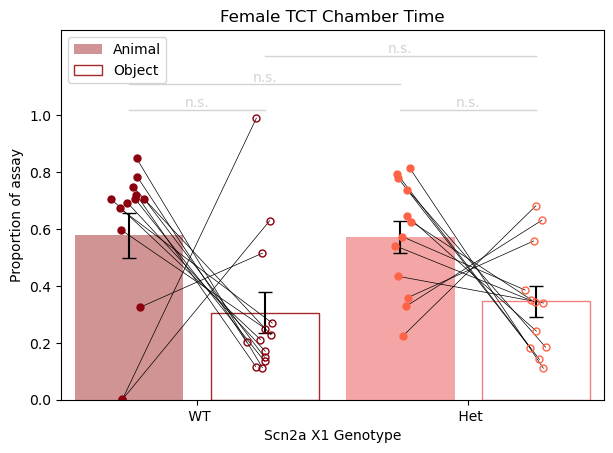

In [1580]:
wtf_side = tct_StatGraph(controlData, 'F', 'side',saveFig = True, figName = 'femaleTCT_region.png')

Female WT Chamber Index vs 0: p = 0.191, wilcoxon signed-rank test
Female Het Chamber Index vs 0: p = 0.067, 1-sample t-test, null = 0
Female WT vs Het Chamber Index: p = 0.463, mann-whitney u test


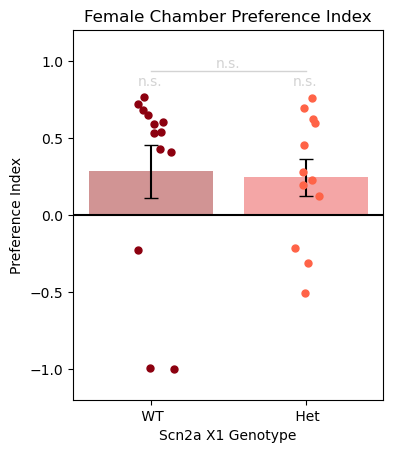

In [1649]:
wtf_sideIdx = tct_StatGraph(controlData, 'F', 'side',mode = 'index',saveFig = True, figName = 'femaleTCT_regionIdx.png')

Female WT animal vs object interaction time: p = 1.476e-03, paired t-test
Female Het animal vs object interaction time: p = 0.016, wilcoxon signed-rank test
Female WT vs Het animal interaction time: p = 0.462, independent samples t-test
Female WT vs Het object interaction time: p = 0.497, mann-whitney u test


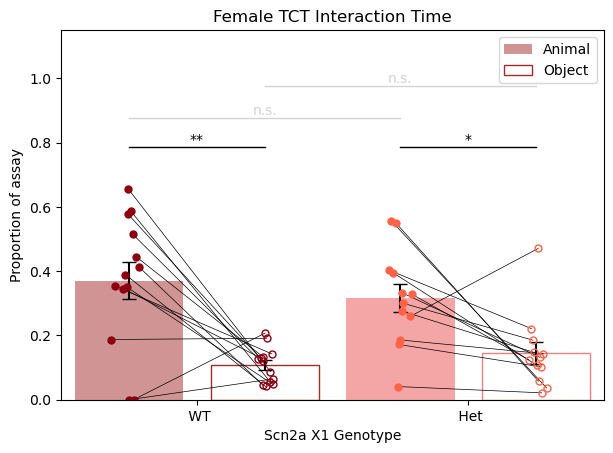

In [1570]:
wtf_intxn = tct_StatGraph(controlData, 'F', 'interact',saveFig = True, figName = 'femaleTCT_intxn.png')

Female WT Interaction Index vs 0: p = 0.191, wilcoxon signed-rank test
Female Het Interaction Index vs 0: p = 1.719e-03, 1-sample t-test, null = 0
Female WT vs Het Interaction Index: p = 0.314, mann-whitney u test


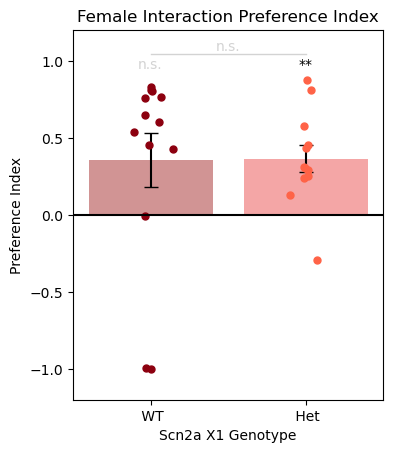

In [1650]:
wtf_intxnIdx = tct_StatGraph(controlData, 'F', 'interact',mode = 'index',saveFig = True, figName = 'femaleTCT_intxnIdx.png')

Male WT animal vs object chamber time: p = 0.102, wilcoxon signed-rank test
Male Het animal vs object chamber time: p = 0.336, paired t-test
Male WT vs Het animal chamber time: p = 0.32, independent samples t-test
Male WT vs Het object chamber time: p = 0.926, mann-whitney u test


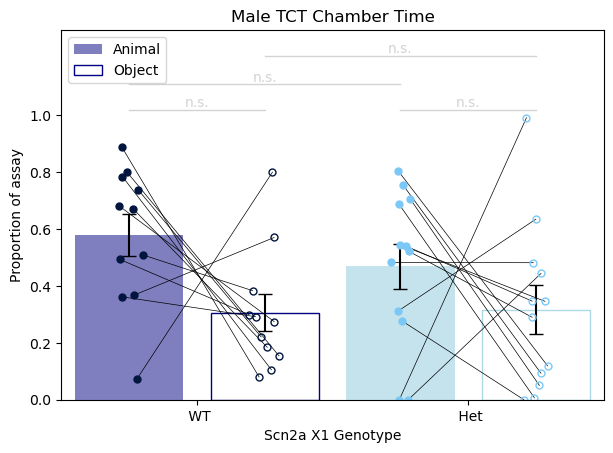

In [1571]:
wtm_side = tct_StatGraph(controlData, 'M', 'side',saveFig = True, figName = 'maleTCT_region.png')

Male WT Chamber Index vs 0: p = 0.073, 1-sample t-test, null = 0
Male Het Chamber Index vs 0: p = 0.286, 1-sample t-test, null = 0
Male WT vs Het Chamber Index: p = 0.799, independent samples t-test


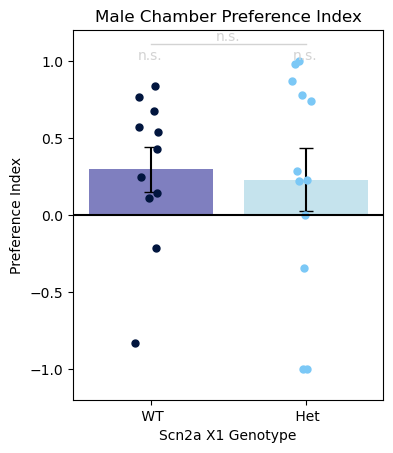

In [1651]:
wtm_sideIdx = tct_StatGraph(controlData, 'M', 'side',mode = 'index',saveFig = True, figName = 'maleTCT_regionIdx.png')

Male WT animal vs object interaction time: p = 0.024, wilcoxon signed-rank test
Male Het animal vs object interaction time: p = 4.164e-03, wilcoxon signed-rank test
Male WT vs Het animal interaction time: p = 0.299, independent samples t-test
Male WT vs Het object interaction time: p = 0.148, mann-whitney u test


/Users/joshsteighner/opt/anaconda3/envs/NS248/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


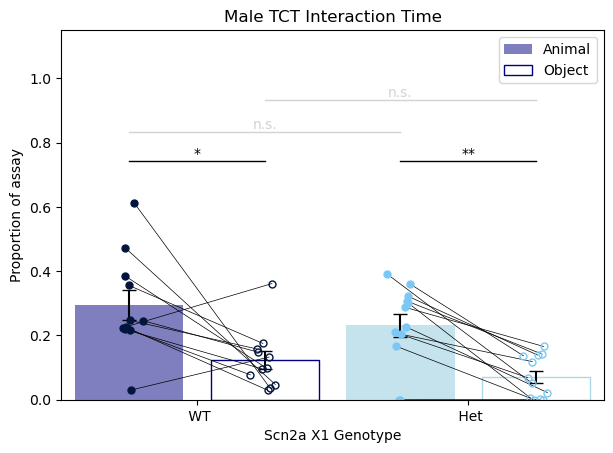

In [1572]:
wtm_intxn = tct_StatGraph(controlData, 'M', 'interact',saveFig = True, figName = 'maleTCT_intxn.png')

Male WT Interaction Index vs 0: p = 0.028, 1-sample t-test, null = 0
Male Het Interaction Index vs 0: p = 0.034, wilcoxon signed-rank test
Male WT vs Het Interaction Index: p = 0.601, mann-whitney u test


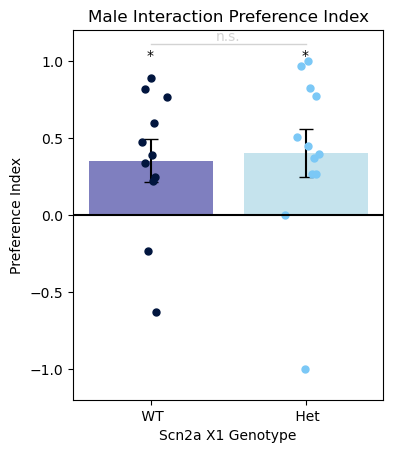

In [1652]:
wtm_intxnIdx = tct_StatGraph(controlData, 'M', 'interact',mode = 'index',saveFig = True, figName = 'maleTCT_intxnIdx.png')